# Kaggle Russian Housing Market Competition EDA #
## -- Project Announcement Weekend
During the weekend immediately after the project announcement Friday, the 4 person team is splitted into 2 subteams.
Chao and Wei would focus on data cleaning and EDA during the initial period of the project, while Sam and Yabin start working on pipeline and code structure asap. The team has decided on a code system built on Python, which is the main reason we are using Python Jupyter Notebook for the EDA. While later on for additional EDA and feature generation we have some freedom switching to R if needed, the main body of the machine learning engine will be in Python. This is largely due to our time constraints -- we only have 2 weeks.

# Update

5/18
    - Comment out the sub_area grouping lines
    - Merge in long lat and OKRUGS (each OKRUGS contains multiple sub_area) info

## Work Flow

1 Data Loading + Missing Value

    1.1 Training Set
    1.2 Testing Set
    1.3 Macro Set
    1.4 Merging (for visualization)
    
2 Data Cleaning + First Pass Visualization

    2.1 Training set first 13 cols cleaning (from Shu's "Data Understanding & Data Preparation" section)
    2.2 Price distribution anamaly deep dive
    2.3 First pass categorical plots
    2.4 Full corr matrix plot (merge train and macro)
    
3 Feature Engineering and Selection

    3.1 Macro cols selection based on VIF
    3.2 Train set feature generation by Shu
    
    --------- Generate Output ---------
        train_clean_shu_0517.csv
        test_clean_shu_0517.csv
    -----------------------------------
    
    3.3 Normalization Features by Wei and Chao (not included in the clean.csv)









## 1 Data Loading + Missing Value (There are more real NA's than what isnull is showing, we will deal with those in the 'data cleaning' step)

In [1]:
import numpy as np 
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import math
import xgboost as xgb
from sklearn import model_selection, preprocessing
from pandas.io.json import build_table_schema
import visualization as vis
from pandas.plotting import scatter_matrix
%matplotlib inline

color = sns.color_palette()

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)  # this is needed since the combined df has ~400 cols

/Users/chao/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_train = pd.read_csv('./Data/train.csv',
                       header='infer', 
                       index_col='id',
                       parse_dates=['timestamp']) # a subfolder named "Data" stores the raw csv files from Kaggle
df_test  = pd.read_csv('./Data/test.csv',
                       header='infer', 
                       index_col='id',
                       parse_dates=['timestamp'])
df_macro = pd.read_csv('./Data/macro.csv',header='infer')

df_subarea = pd.read_csv('./Data/sub_area_lon_lat.csv',header='infer')
df_subarea = df_subarea.drop(df_subarea.columns[0], axis=1)

In [3]:
print(df_train.shape)
print(df_test.shape)
print(df_macro.shape) # econ data
print(df_subarea.shape)

(30471, 291)
(7662, 290)
(2484, 100)
(146, 4)


In [4]:
df_subarea.head()

,lon,lat,sub_area,OKRUGS
0,36.900248,55.389158,Poselenie Kievskij,Troitsky
1,37.486849,55.749249,Filevskij Park,Western
2,36.947210,55.443827,Poselenie Novofedorovskoe,Troitsky
3,37.064663,55.220557,Poselenie Rogovskoe,Troitsky
4,37.465806,55.618792,Poselenie Mosrentgen,Novomoskovsky


test to train ratio is about 0.25    (7662/30471)

### 1.1 Training Data Set

In [5]:
df_train.head() # 291 cols (0-290), description is in the dictionary file

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [6]:
datatype_train = pd.DataFrame(df_train.dtypes.value_counts().reset_index().rename(columns ={"index":'Variable_type',0:'count'} ))
print(datatype_train)

    Variable_type  count
0           int64    156
1         float64    119
2          object     15
3  datetime64[ns]      1


In [7]:
df_train.columns.tolist()

['timestamp',
 'full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'product_type',
 'sub_area',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'children_preschool',
 'preschool_quota',
 'preschool_education_centers_raion',
 'children_school',
 'school_quota',
 'school_education_centers_raion',
 'school_education_centers_top_20_raion',
 'hospital_beds_raion',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'male_f',
 'female_f',
 'young_all',
 'young_male',
 'young_female',
 'work_all',
 'work_male',
 'work_female',
 'ekder_all',
 'ekd

### High Level Column Content Digestion Notes

'**timestamp**'(0): this is what makes this competition special -- it has a time dimension. **The training data set and test data set do NOT overlap in time**. The macro economy csv files covers the whole time range of train + test.

'**full_sq**' to '**state**'(1-9): these are detailed description of each listing unit. 

'**product_type**'(10): investment or owner occupied

'**sub_area**' to '**build_count_after_1995**'(11-82): neighborhood info. **For all the listings in the same sub_area, all info in col 12-83 are the SAME. When comparing listings in the same sub_area, all these columns are useless.** If we take the intuitive approach to predict price only using the training info from the same sub_area, these columns would be useless. Input and target distribution for each sub_area need to be looked at. 

'**ID_metro**' to '**ecology**'(83-151): These are listing specific info. Most of them are distances (in km) to the nearest POI's. A few of them have **ID**'s, which can be used to further pin down where the listing is within a sub_area, especially with a map. The distance items could be potentially be grouped into 'good' and 'bad' POI's, and do a sum of 1/d to get "number of good/bad stuff per 1 km" feature. A few things like ecology are categorical, and should be important for predicting housing price.

**Everything after ecology till the last column**(152-289): these are POI counts for specific radius. It is important to think about the spatial sensitivity decay when we increase the radius. To reduce multicollinearity, I think it's better to do a few subtraction to get counts in a donut area, so columns are more independent from each other.

'**price_doc**'(290): This is the price we try to predict.

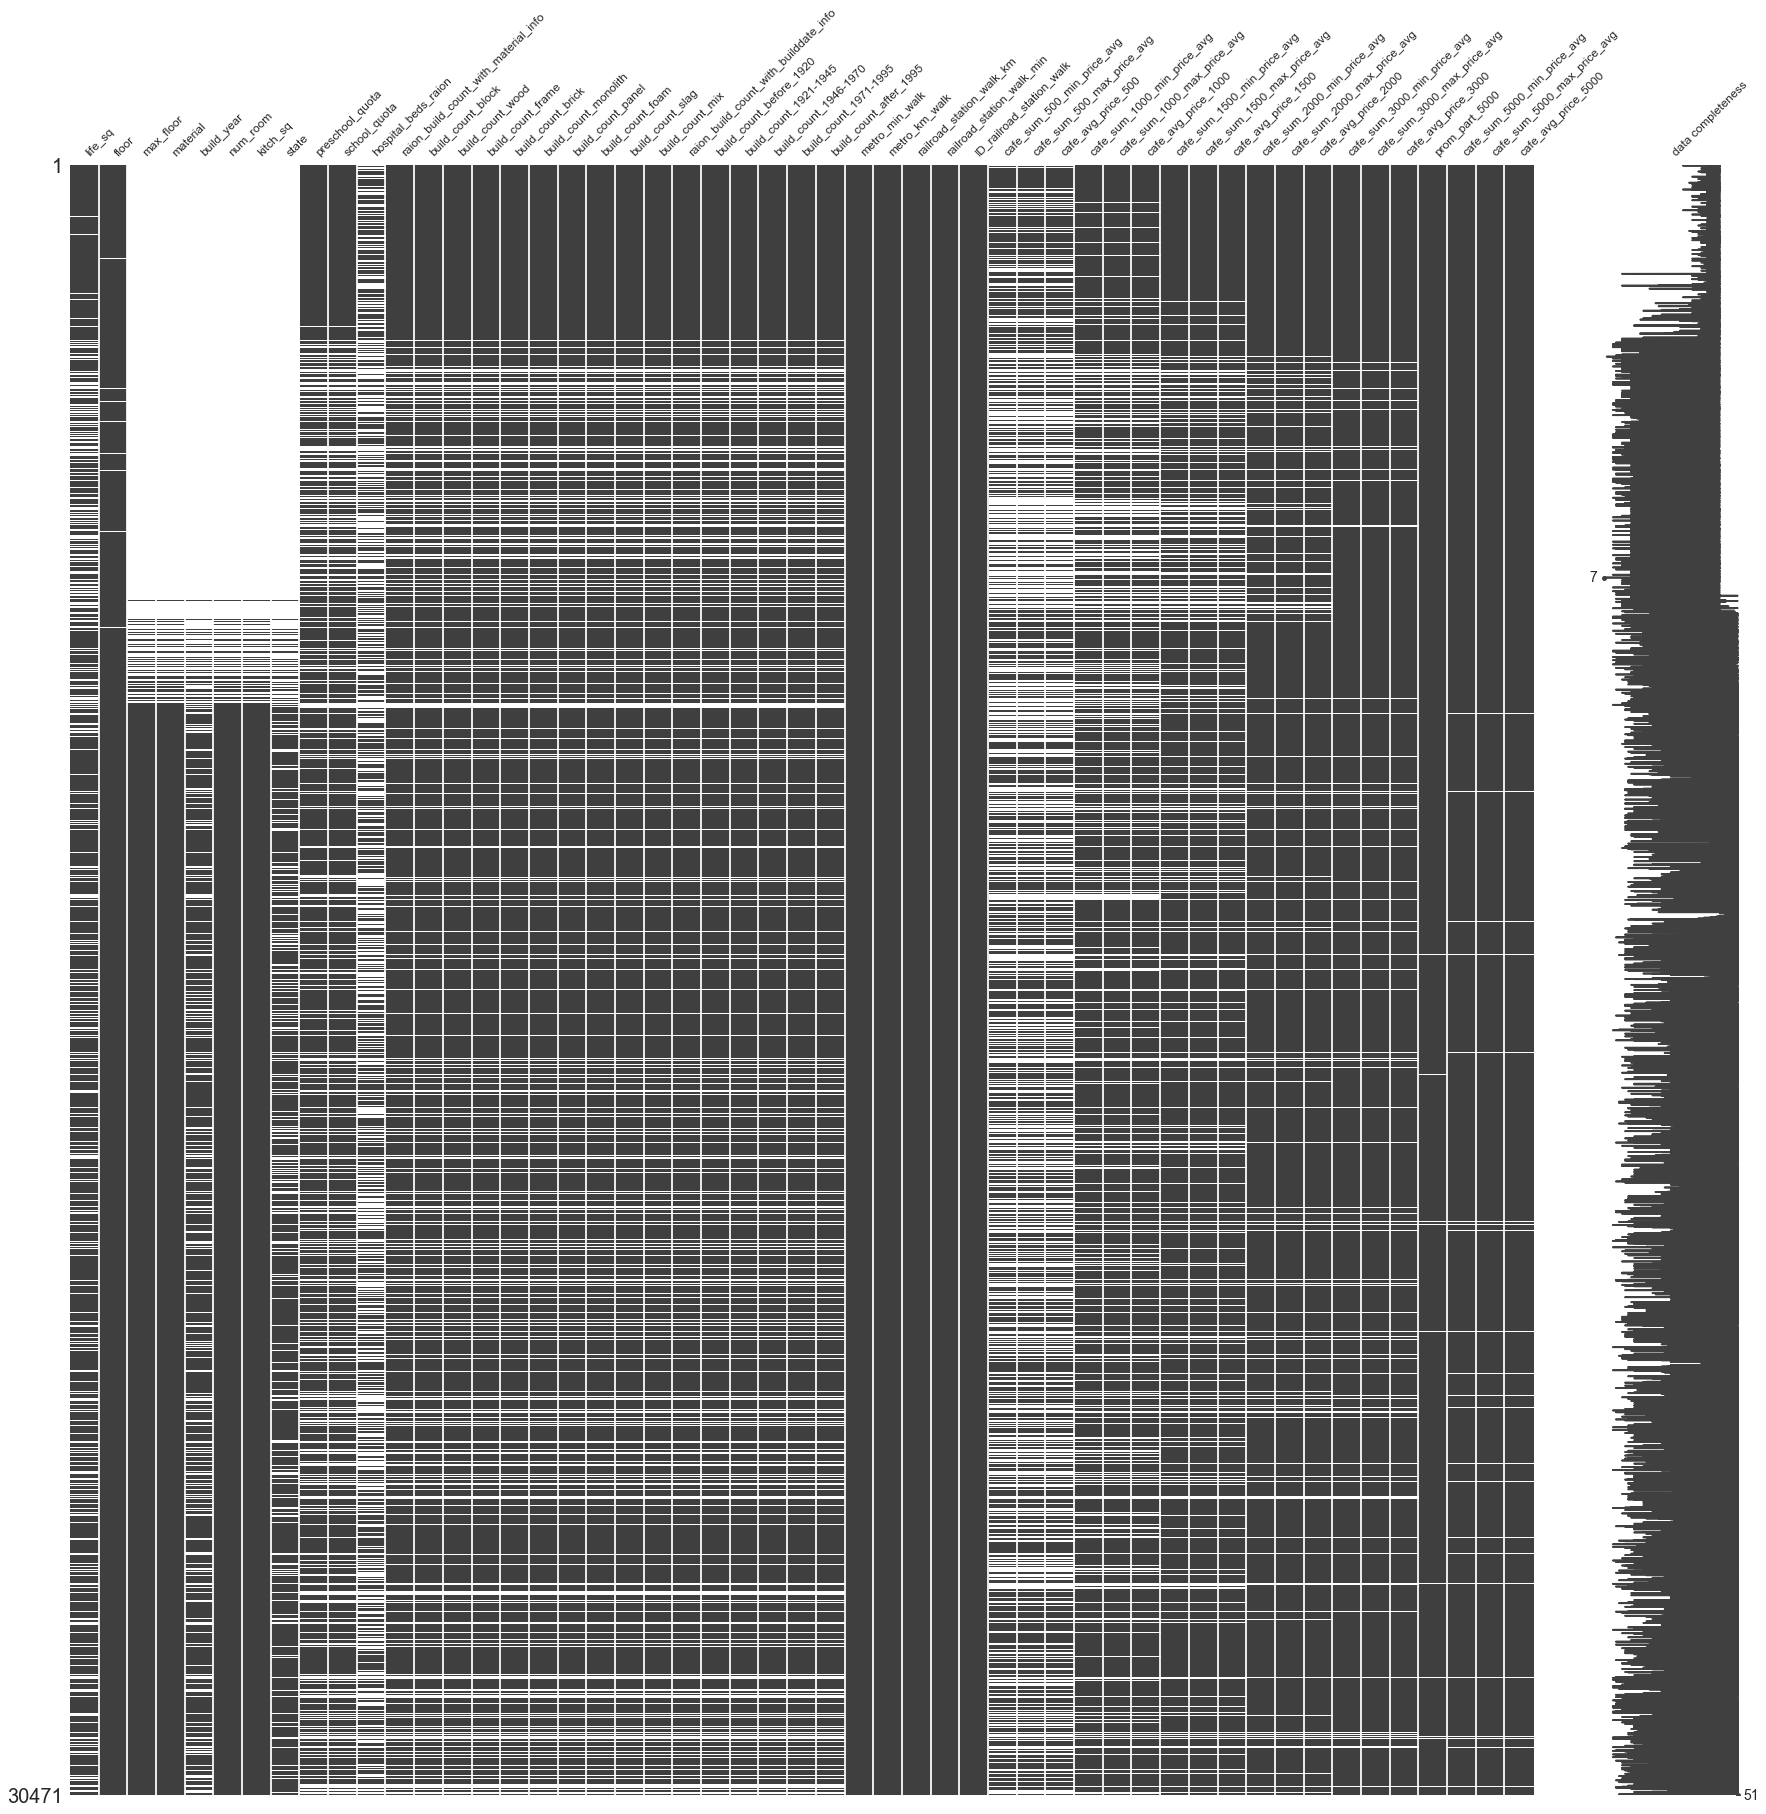

In [8]:
# find out columns with missing values 
missingvalue_columns = df_train.columns[df_train.isnull().any()].tolist()

msno.matrix(df_train[missingvalue_columns],
            width_ratios=(10,1),
            figsize=(30,30),
            fontsize=12,
            sparkline=True,
            labels=True)

In [9]:
num_missingvalue_columns_train = df_train.isnull().sum(axis=0)
ratio_missingvalue_columns_train = num_missingvalue_columns_train/df_train.shape[0]
ratio_missingvalue_columns_train[ratio_missingvalue_columns_train>0]

life_sq                                  0.209478
floor                                    0.005481
max_floor                                0.314135
material                                 0.314135
build_year                               0.446490
num_room                                 0.314135
kitch_sq                                 0.314135
state                                    0.444980
preschool_quota                          0.219487
school_quota                             0.219389
hospital_beds_raion                      0.473926
raion_build_count_with_material_info     0.163795
build_count_block                        0.163795
build_count_wood                         0.163795
build_count_frame                        0.163795
build_count_brick                        0.163795
build_count_monolith                     0.163795
build_count_panel                        0.163795
build_count_foam                         0.163795
build_count_slag                         0.163795


In [10]:
# missing value for each column
print (ratio_missingvalue_columns_train[ratio_missingvalue_columns_train>0].shape[0])
print (ratio_missingvalue_columns_train.shape[0])

# total missing value
total_missingvalue_train = df_train.isnull().sum().sum()
print (1.0*total_missingvalue_train/df_train.shape[0]/df_train.shape[1])
# df_train.shape[0]*df_train.shape[1]
# total_missingvalue

51
291
0.0294377133528


A few columns could miss almost half of the values. 51 out of 292 columns miss value (51/292= 17.47%).
In total there are 2.93% value missing

### 1.2 Test Data Set

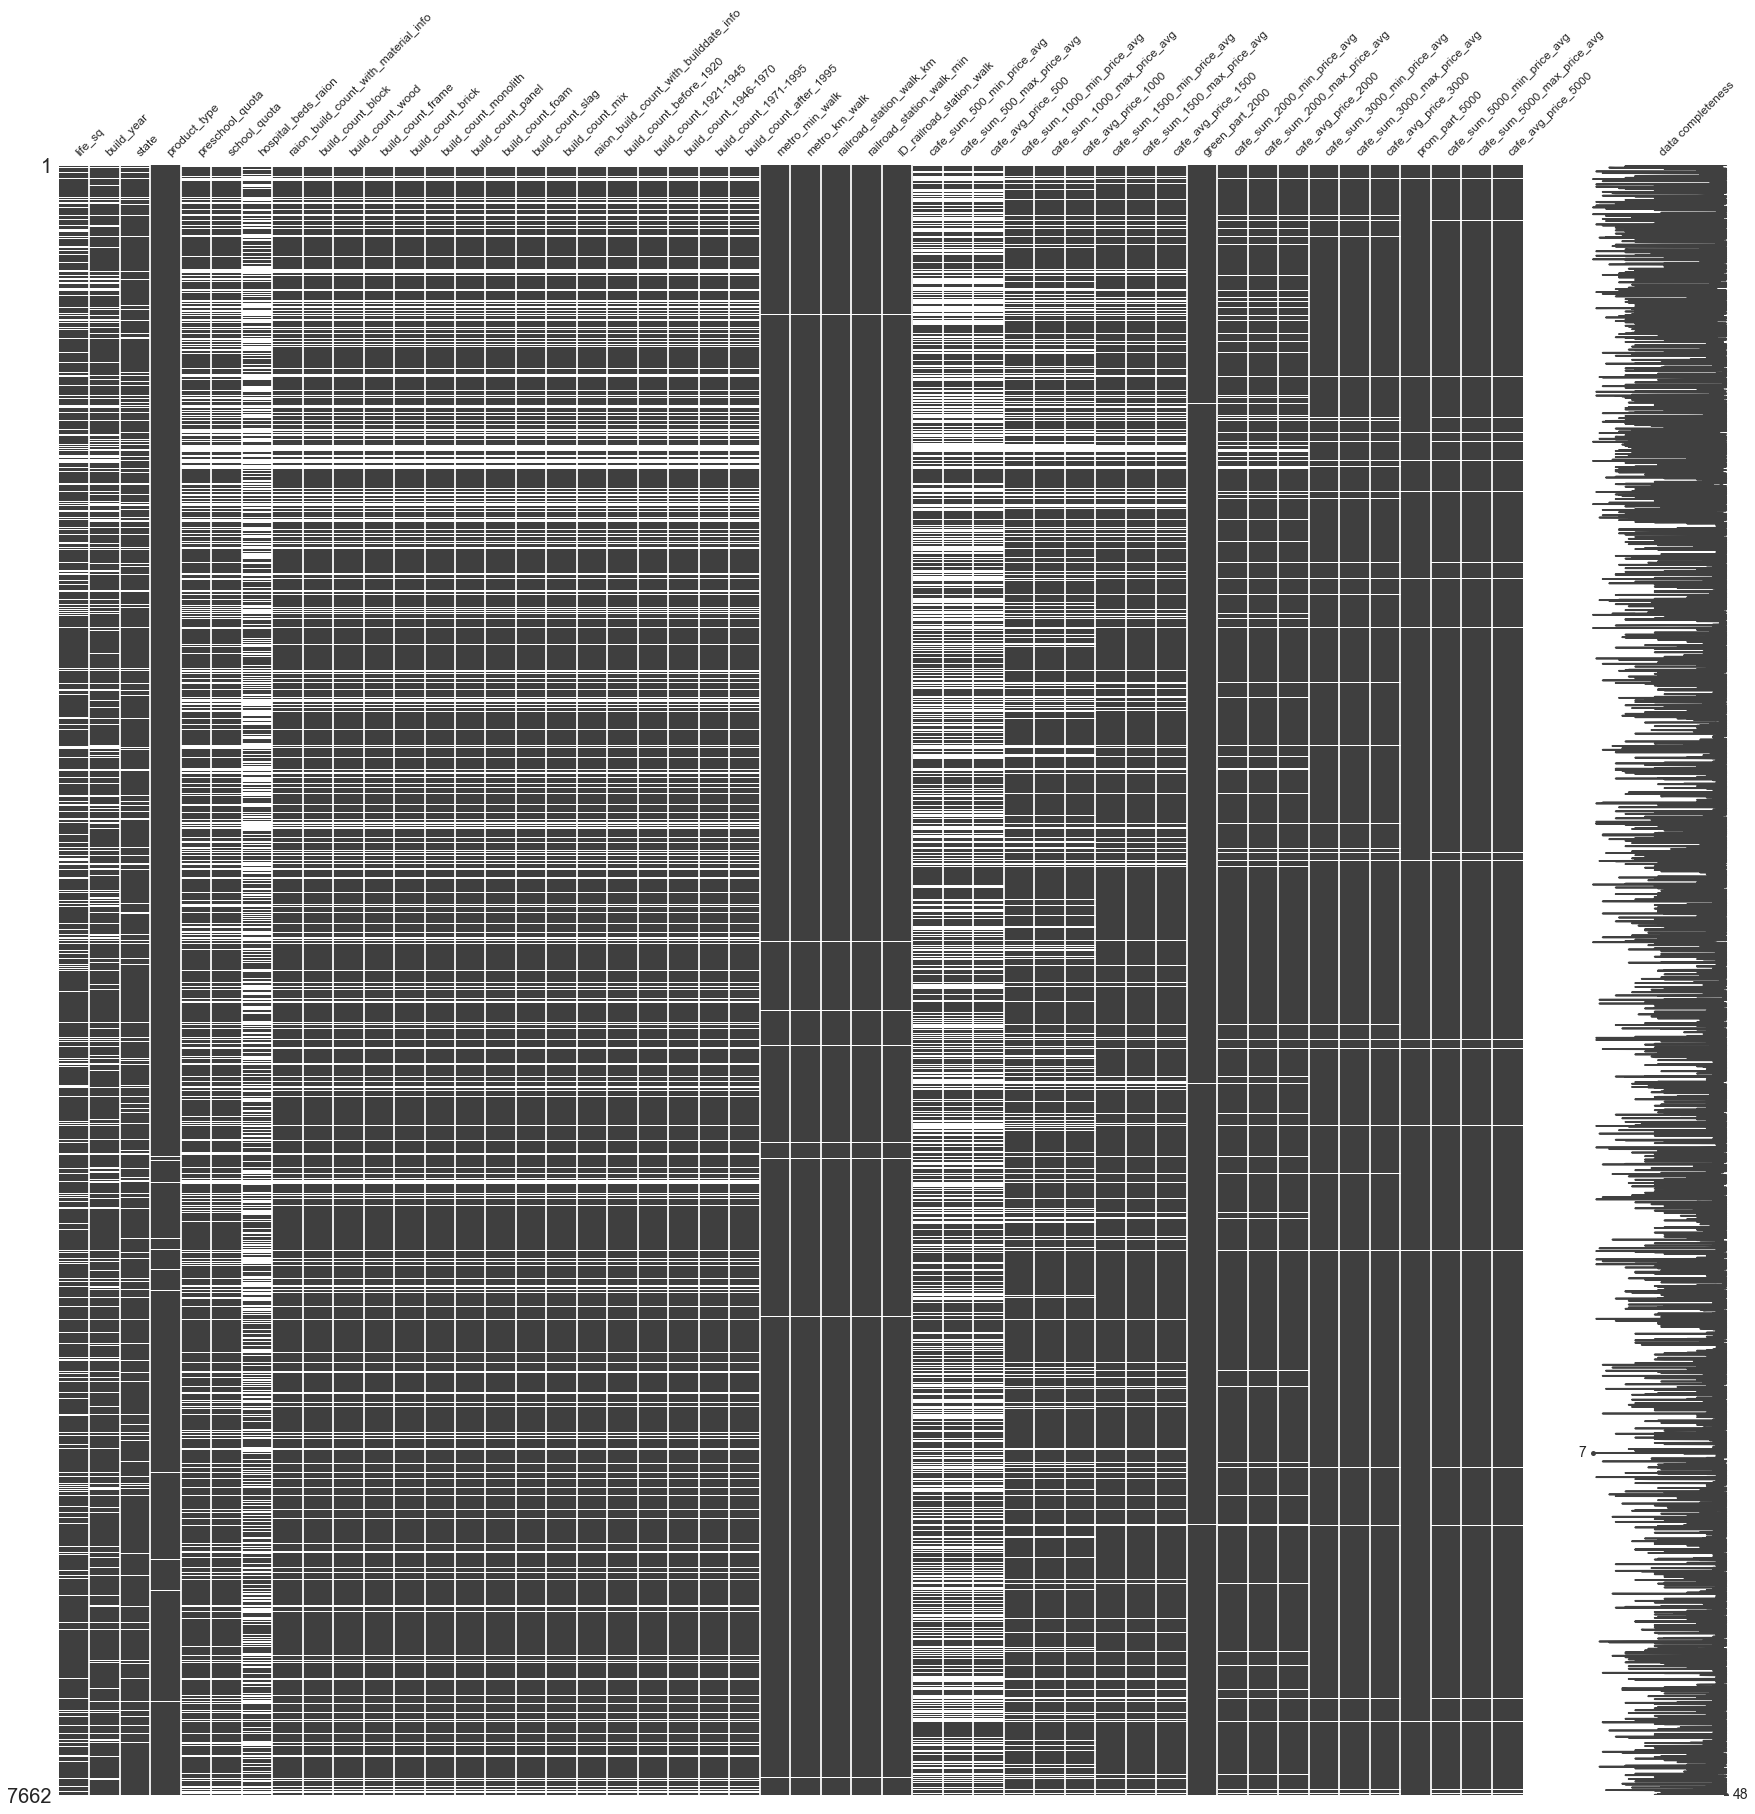

In [11]:
# find out columns with missing values 
missingvalue_columns_test = df_test.columns[df_test.isnull().any()].tolist()

msno.matrix(df_test[missingvalue_columns_test],
            width_ratios=(10,1),
            figsize=(30,30),
            fontsize=12,
            sparkline=True,
            labels=True)

In [12]:
num_missingvalue_columns_test = df_test.isnull().sum(axis=0)
ratio_missingvalue_columns_test = num_missingvalue_columns_test/df_test.shape[0]
ratio_missingvalue_columns_test[ratio_missingvalue_columns_test>0]

life_sq                                  0.153485
build_year                               0.136909
state                                    0.090577
product_type                             0.004307
preschool_quota                          0.208301
school_quota                             0.208170
hospital_beds_raion                      0.446098
raion_build_count_with_material_info     0.158966
build_count_block                        0.158966
build_count_wood                         0.158966
build_count_frame                        0.158966
build_count_brick                        0.158966
build_count_monolith                     0.158966
build_count_panel                        0.158966
build_count_foam                         0.158966
build_count_slag                         0.158966
build_count_mix                          0.158966
raion_build_count_with_builddate_info    0.158966
build_count_before_1920                  0.158966
build_count_1921-1945                    0.158966


In [13]:
# missing value for each column
print (ratio_missingvalue_columns_test[ratio_missingvalue_columns_test>0].shape[0])
print (ratio_missingvalue_columns_test.shape[0])

# total missing value
total_missingvalue_test = df_test.isnull().sum().sum()
print (1.0*total_missingvalue_test/df_test.shape[0]/df_test.shape[1])

48
290
0.0212144123709


A few columns could miss almost half of the values. 48 out of 292 columns miss value (48/292= 16.44%). In total there are 2.11% value missing.

Even percentage-wise, the test set has less missing values than train set.

### Missing Value Comparison Between Train and Test Sets

In [14]:
train_col_mis = ratio_missingvalue_columns_train[ratio_missingvalue_columns_train>0]
test_col_mis  = ratio_missingvalue_columns_test[ratio_missingvalue_columns_test>0]

print('These columns have missing values in TRAIN, but not in TEST')
print train_col_mis.index[~train_col_mis.index.isin(test_col_mis.index)]

print('These columns have missing values in TEST, but not in TRAIN')
print test_col_mis.index[~test_col_mis.index.isin(train_col_mis.index)]

These columns have missing values in TRAIN, but not in TEST
Index([u'floor', u'max_floor', u'material', u'num_room', u'kitch_sq'], dtype='object')
These columns have missing values in TEST, but not in TRAIN
Index([u'product_type', u'green_part_2000'], dtype='object')


### 1.3 Macro Economy Data

In [15]:
# data type of macro
datatype_macro = pd.DataFrame(df_macro.dtypes.value_counts().
                        reset_index().
                        rename(columns ={"index":'Variable_type',0:'count'} ))
print(datatype_macro)

  Variable_type  count
0       float64     94
1        object      4
2         int64      2


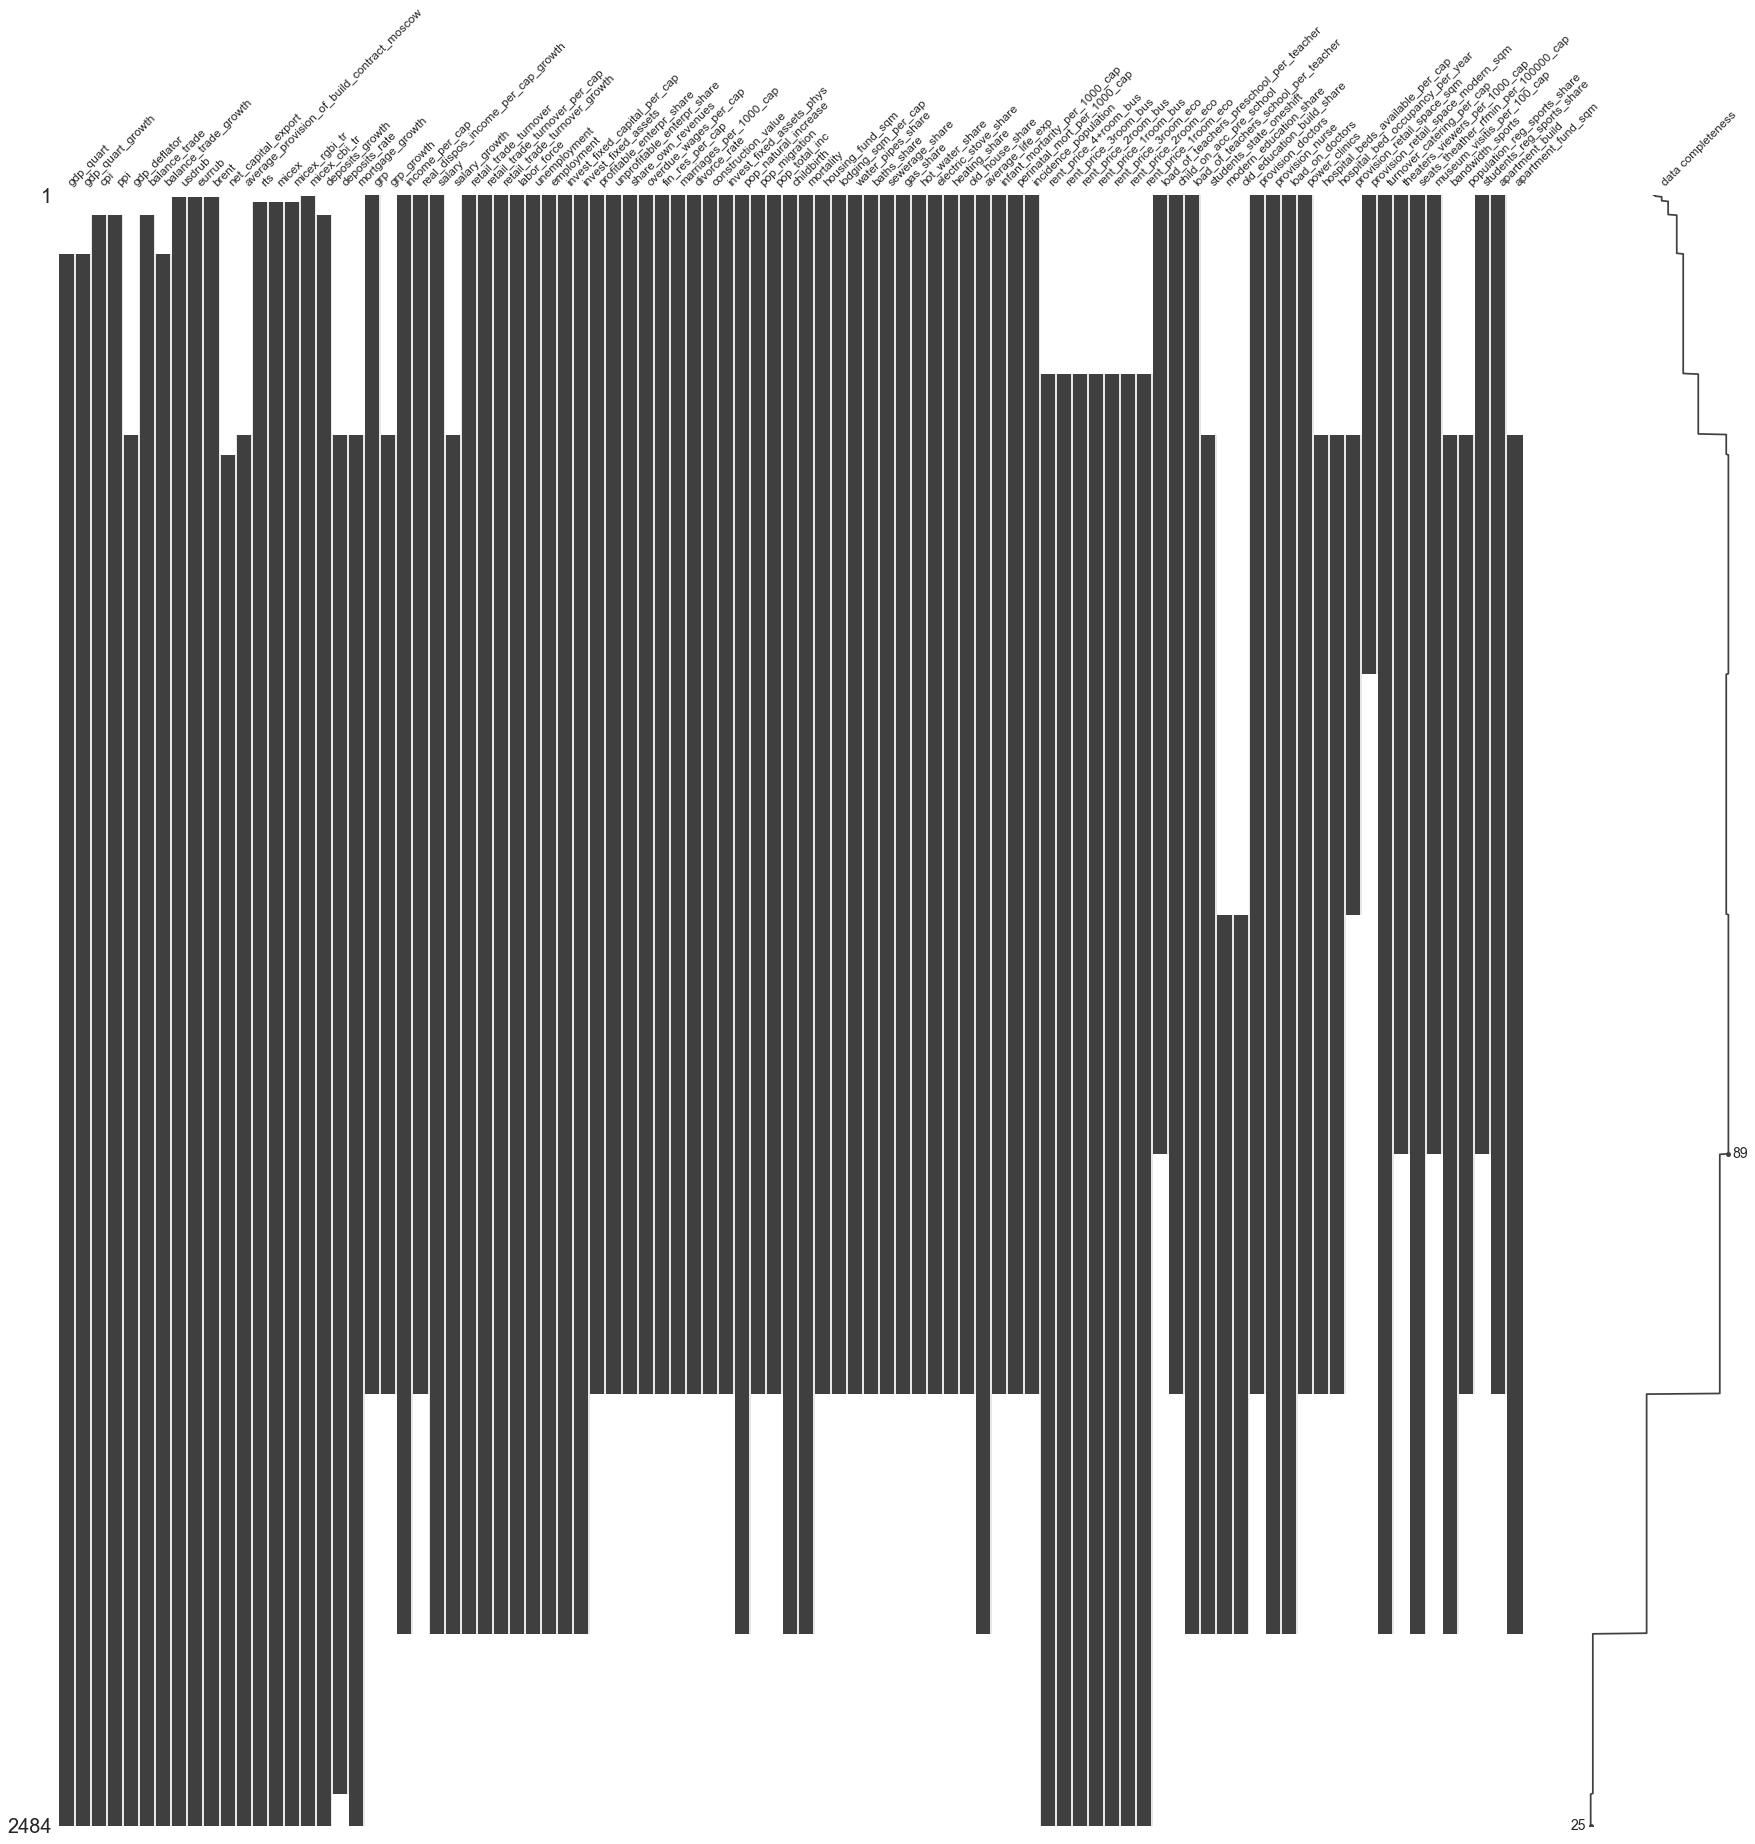

In [16]:
missingvalue_columns_macro = df_macro.columns[df_macro.isnull().any()].tolist()

msno.matrix(df_macro[missingvalue_columns_macro],
            width_ratios=(10,1),
            figsize=(30,30),
            fontsize=12,
            sparkline=True,
            labels=True)

In [17]:
num_missingvalue_columns_macro = df_macro.isnull().sum(axis=0)
ratio_missingvalue_columns_macro = num_missingvalue_columns_macro/df_macro.shape[0]
ratio_missingvalue_columns_macro[ratio_missingvalue_columns_macro>0]

gdp_quart                                     0.036232
gdp_quart_growth                              0.036232
cpi                                           0.012480
ppi                                           0.012480
gdp_deflator                                  0.146940
balance_trade                                 0.012480
balance_trade_growth                          0.036232
usdrub                                        0.001208
eurrub                                        0.001208
brent                                         0.001208
net_capital_export                            0.159420
average_provision_of_build_contract_moscow    0.146940
rts                                           0.004026
micex                                         0.004026
micex_rgbi_tr                                 0.004026
micex_cbi_tr                                  0.000403
deposits_growth                               0.012480
deposits_rate                                 0.166667
mortgage_g

In [18]:
# missing value for each column
print (ratio_missingvalue_columns_macro[ratio_missingvalue_columns_macro>0].shape[0])
print (ratio_missingvalue_columns_macro.shape[0])

# total missing value
total_missingvalue_macro = df_macro.isnull().sum().sum()
print (1.0*total_missingvalue_macro/df_test.shape[0]/df_macro.shape[1])

91
100
0.0608953275907


A few columns could miss almost half of the values. 91 out of 100 columns miss value (91%). In total there are 6.08% value missing.

### 1.4 Merge train , test datasets with macro on 'timestamp' column 
**This does NOT mean we will start by pushing the entire input data into a black box. This merge is for certain EDA visualization. We will need to understand the data piece by piece.**

In [19]:
df_macro.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in df_macro.columns ]

df_train_macro = df_train.merge(df_macro,on='timestamp',how = 'left')
df_test_macro  = df_test.merge(df_macro,on='timestamp',how = 'left')

print(df_train_macro.shape)
print(df_test_macro.shape)

(30471, 390)
(7662, 389)


## 2 Data Cleaning + First Pass Visualization

### 2.1 Train set first 13 cols cleaning (from Shu)

In [20]:
## data schema
train_schema = pd.DataFrame(build_table_schema(df_train)['fields'])
macro_schema = pd.DataFrame(build_table_schema(df_macro)['fields'])

In [21]:
## start from property features first
property_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                     'max_floor', 'material', 'build_year', 'num_room',
                     'kitch_sq', 'state', 'product_type', 'sub_area', 
                     'price_doc']

train = df_train[property_features]
test  = df_test[property_features[:-1]]

In [22]:
train.shape

(30471, 13)

- Check price_doc distribution

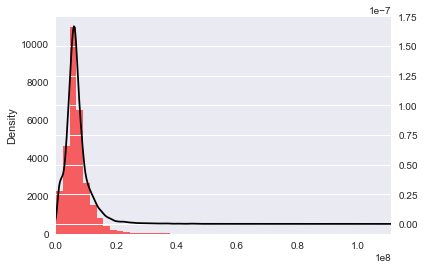

In [23]:
## distribution of price_doc
vis.hist_density_plot(train, x='price_doc')

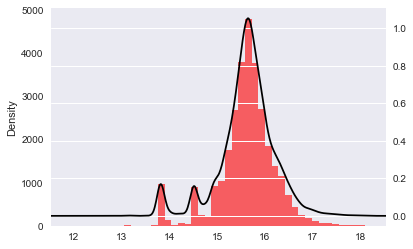

In [24]:
## distribution of log(price_doc+1)
vis.hist_density_plot(train, x='price_doc', logx=True)

- Check features: material

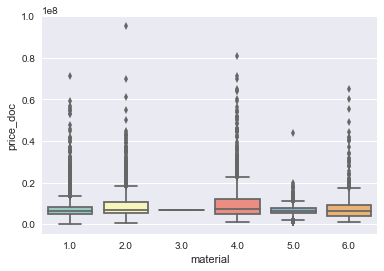

In [25]:
## material
sns.boxplot(x='material', 
            y='price_doc', 
            data=train, 
            palette='Set3')

In [26]:
print(train['material'].value_counts(dropna=False))
print(test['material'].value_counts(dropna=False))

 1.0    14197
NaN      9572
 2.0     2993
 5.0     1561
 4.0     1344
 6.0      803
 3.0        1
Name: material, dtype: int64
1    5241
2     958
4     619
5     487
6     356
3       1
Name: material, dtype: int64


In [27]:
## set level 3 to np.nan
train.loc[train['material'] == 3, 'material'] = np.nan
test.loc[test['material'] == 3, 'material'] = np.nan

- Check features : state

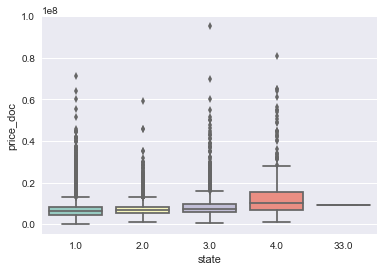

In [28]:
## state
sns.boxplot(x='state', 
            y='price_doc', 
            data=train, 
            palette='Set3')

In [29]:
print(train['state'].value_counts(dropna=False))
print(test['state'].value_counts(dropna=False))

NaN      13559
 2.0      5844
 3.0      5790
 1.0      4855
 4.0       422
 33.0        1
Name: state, dtype: int64
 2.0    2662
 1.0    2266
 3.0    1913
NaN      694
 4.0     127
Name: state, dtype: int64


In [30]:
## change 33 to 3
train.loc[train['state'] == 33, 'state'] = 3

- Check features: product_type

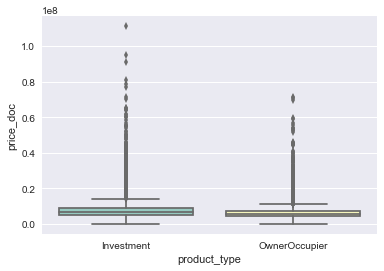

In [31]:
## product_type
sns.boxplot(x='product_type', 
            y='price_doc', 
            data=train, 
            palette='Set3')

In [32]:
## keep product_type as it is
print(train['product_type'].value_counts(dropna=False))
print(test['product_type'].value_counts(dropna=False))

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64
Investment       4998
OwnerOccupier    2631
NaN                33
Name: product_type, dtype: int64


- Check features: floor / max_floor

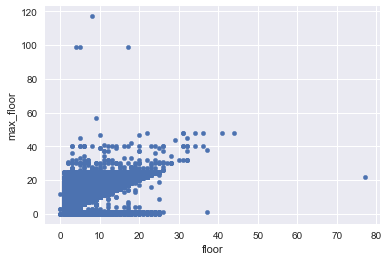

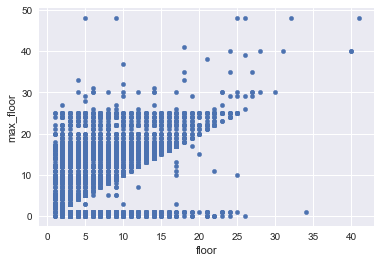

In [33]:
## floor / max_floor
train.plot.scatter(x='floor', y='max_floor')
test.plot.scatter(x='floor', y='max_floor')

In [34]:
## max_floor
train.loc[train['max_floor'] > 60]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
20725,2014-07-10,47,47.0,4.0,99.0,2.0,NaN,1.0,1.0,NaN,OwnerOccupier,Pokrovskoe Streshnevo,10238400
21737,2014-08-21,71,71.0,5.0,99.0,6.0,NaN,2.0,9.0,NaN,OwnerOccupier,Poselenie Moskovskij,8484365
21855,2014-08-25,46,46.0,17.0,99.0,6.0,NaN,3.0,9.0,NaN,OwnerOccupier,Poselenie Sosenskoe,6670000
25943,2014-12-06,63,63.0,8.0,117.0,1.0,NaN,2.0,1.0,1.0,OwnerOccupier,Tverskoe,7239838


In [35]:
## max_floor: change 117 to 17, change 99 to np.nan
train.loc[train['max_floor'] == 117, 'max_floor'] = 17
train.loc[train['max_floor'] > 60, 'max_floor'] = np.nan

In [36]:
## floor
train.loc[train['floor'] > 60]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
23587,2014-10-15,57,33.0,77.0,22.0,1.0,1986.0,2.0,10.0,3.0,Investment,Lomonosovskoe,13700000


In [37]:
## floor: change 77 to 7
train.loc[train['floor'] == 77, 'floor'] = 7

- Check features: build_year

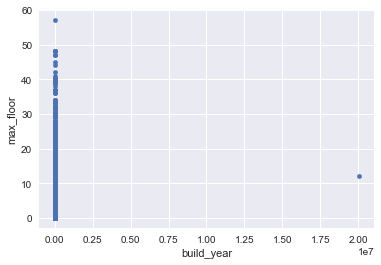

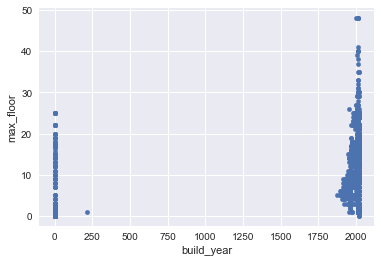

In [38]:
## build_year (training set)
train.plot.scatter(x='build_year', y='max_floor')
test.plot.scatter(x='build_year', y='max_floor')

In [39]:
train['build_year'].value_counts(dropna=False).sort_index()

 0.0             530
 1.0             368
 3.0               2
 20.0              1
 71.0              1
 215.0             1
 1691.0            1
 1860.0            2
 1876.0            1
 1886.0            1
 1890.0            5
 1895.0            1
 1896.0            2
 1900.0            2
 1904.0            1
 1905.0            1
 1906.0            1
 1907.0            2
 1910.0            5
 1911.0            1
 1912.0            5
 1914.0            3
 1915.0            5
 1917.0           16
 1920.0            1
 1924.0            3
 1925.0            1
 1926.0            8
 1927.0           10
 1928.0           12
               ...  
 1992.0          139
 1993.0          115
 1994.0          160
 1995.0          149
 1996.0          162
 1997.0          139
 1998.0          141
 1999.0          125
 2000.0          130
 2001.0          177
 2002.0          214
 2003.0          193
 2004.0          220
 2005.0          176
 2006.0          242
 2007.0          219
 2008.0      

In [40]:
## training build_year: 20052009 to 2009, 4965 to 1965, 71 to 1971, year < 1800 to np.nan
train.loc[train['build_year'] == 20052009, 'build_year'] = 2009
train.loc[train['build_year'] == 4965, 'build_year'] = 1965
train.loc[train['build_year'] == 71, 'build_year'] = 1971
train.loc[train['build_year'] < 1800, 'build_year'] = np.nan

In [41]:
test['build_year'].value_counts(dropna=False).sort_index()

 0.0        369
 1.0        187
 2.0          1
 215.0        1
 1875.0       1
 1890.0       2
 1895.0       1
 1898.0       1
 1902.0       1
 1905.0       1
 1906.0       1
 1908.0       1
 1910.0       1
 1911.0       3
 1912.0       1
 1914.0       2
 1917.0       3
 1924.0       1
 1926.0       8
 1927.0       3
 1928.0       6
 1929.0       4
 1930.0       3
 1931.0       3
 1932.0       3
 1933.0       1
 1935.0       1
 1937.0       5
 1938.0       3
 1939.0       3
           ... 
 1991.0      28
 1992.0      56
 1993.0      39
 1994.0      49
 1995.0      40
 1996.0      44
 1997.0      58
 1998.0      46
 1999.0      53
 2000.0      56
 2001.0      63
 2002.0      65
 2003.0      61
 2004.0      66
 2005.0      65
 2006.0      92
 2007.0      46
 2008.0      74
 2009.0      58
 2010.0      47
 2011.0      61
 2012.0      74
 2013.0     260
 2014.0     199
 2015.0     259
 2016.0     400
 2017.0     413
 2018.0      30
 2019.0       5
NaN        1049
Name: build_year, Length

In [42]:
## test build_year: year < 1800 to np.nan
test.loc[test['build_year'] < 1800, 'build_year'] = np.nan

- Check features: num_room / full_sq / life_sq

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112af3590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c11ced0>]], dtype=object)

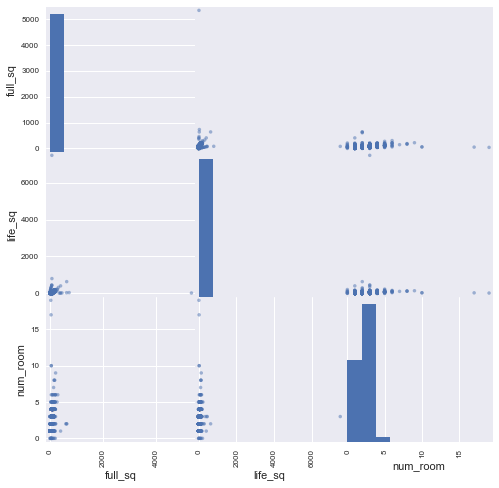

In [43]:
## num_room / full_sq / life_sq (training set)
scatter_matrix(train.loc[:, ['full_sq', 'life_sq', 'num_room']], 
               figsize=(8, 8), 
               diagonal='hist')

In [44]:
## num_room
train.loc[train['num_room'] > 9]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
11624,2013-10-28,40,19.0,17.0,17.0,1.0,2011.0,19.0,7.0,3.0,Investment,Poselenie Vnukovskoe,2630000
17767,2014-04-23,58,34.0,1.0,2.0,1.0,1992.0,10.0,10.0,2.0,Investment,Krjukovo,6000000
26716,2014-12-18,51,30.0,14.0,17.0,1.0,1984.0,17.0,8.0,3.0,Investment,Obruchevskoe,13150000
29175,2015-04-16,59,33.0,20.0,22.0,1.0,2000.0,10.0,10.0,3.0,Investment,Mar'ino,11000000


In [45]:
## change: num_room > 9 to np.nan num_room < 1 to np.nan
train.loc[train['num_room'] > 9, 'num_room'] = np.nan
train.loc[train['num_room'] < 1, 'num_room'] = np.nan

In [46]:
## full_sq 
train.loc[train['full_sq'] > 300]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
129,2011-10-15,325,325.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Ivanovskoe,5000000
1481,2012-03-11,353,20.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Solncevo,4750000
1613,2012-03-21,394,17.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Ljublino,1050000
2428,2012-06-07,412,17.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Filevskij Park,6117000
2783,2012-07-06,729,44.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Troparevo-Nikulino,13250000
3530,2012-09-07,5326,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Birjulevo Vostochnoe,6868818
3599,2012-09-12,388,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Nekrasovka,3899400
5947,2013-02-07,634,38.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Lianozovo,10200000
7210,2013-04-10,461,27.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Vyhino-Zhulebino,5750000


In [47]:
## change: 5326 to 53.26, full_sq > 310 divided by 10, full_sq < 2 to np.nan
train.loc[3530, 'full_sq'] = 5326/100
train.loc[train['full_sq'] > 310, 'full_sq'] = train.loc[train['full_sq'] > 310, 'full_sq']/10
train.loc[train['full_sq'] < 2, 'full_sq'] = np.nan

In [48]:
## check life_sq
train.loc[(train['full_sq'] < train['life_sq']) & (train['life_sq'] > 100)]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
129,2011-10-15,32.5,325.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Ivanovskoe,5000000
1085,2012-02-06,44.0,281.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6200000
1866,2012-04-11,30.0,178.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Presnenskoe,5900000
4388,2012-10-25,73.0,426.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Vojkovskoe,11918400
6339,2013-03-06,37.0,191.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Kosino-Uhtomskoe,5400000
7211,2013-04-10,31.0,195.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Cheremushki,6400000
9240,2013-07-16,47.0,301.0,4.0,12.0,1.0,1973.0,2.0,6.0,2.0,Investment,Birjulevo Zapadnoe,5600000
9259,2013-07-17,77.0,458.0,12.0,16.0,1.0,1996.0,3.0,10.0,3.0,Investment,Jasenevo,13750000
9649,2013-08-06,82.0,802.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Chertanovo Juzhnoe,12031350


In [49]:
## changes: life_sq[13549] to life_sq[13549]/100, rest divided by 10, life_sq < 2 to np.nan
train.loc[13549, 'life_sq'] = train.loc[13549, 'life_sq'] / 100
rows = (train['full_sq'] < train['life_sq']) & (train['life_sq'] > 100)
train.loc[rows, 'life_sq'] = train.loc[rows, 'life_sq'] / 10
train.loc[train['life_sq'] < 2, 'life_sq'] = np.nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bd6fbd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117a4ac10>]], dtype=object)

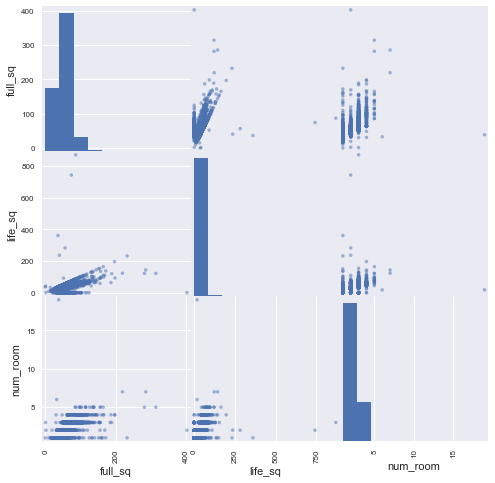

In [50]:
## num_room / full_sq / life_sq (test set)
scatter_matrix(test.loc[:, ['full_sq', 'life_sq', 'num_room']], 
               figsize=(8, 8), 
               diagonal='hist')

In [51]:
## num_room
test.loc[test['num_room'] > 9, 'num_room'] = np.nan

In [52]:
## full_sq 
test.loc[test['full_sq'] > 400, 'full_sq'] = test.loc[test['full_sq'] > 400, 'full_sq'] / 10
test.loc[test['full_sq'] < 3, 'full_sq'] = np.nan

In [53]:
## life_sq
rows = (test['full_sq'] < test['life_sq']) & (test['life_sq'] > 110)
test.loc[rows]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area
id,,,,,,,,,,,,
31075,2015-08-17,74.2,742.0,2,17,1.0,NaN,2.0,1.0,1.0,OwnerOccupier,Poselenie Sosenskoe
32370,2015-10-23,36.1,361.0,14,14,4.0,NaN,1.0,0.0,1.0,OwnerOccupier,Poselenie Sosenskoe
32505,2015-10-30,40.2,237.0,11,11,1.0,2016.0,2.0,67.0,1.0,OwnerOccupier,Horoshevo-Mnevniki
33265,2015-12-01,86.9,869.0,3,20,4.0,NaN,3.0,0.0,1.0,OwnerOccupier,Chertanovo Juzhnoe
35661,2016-02-15,56.3,283.0,7,17,1.0,2014.0,2.0,8.3,2.0,Investment,Sokolinaja Gora


In [54]:
test.loc[rows, 'life_sq'] = test.loc[rows, 'life_sq'] / 10
test.loc[test['life_sq'] < 3, 'life_sq'] = np.nan

- Check features: kitch_sq

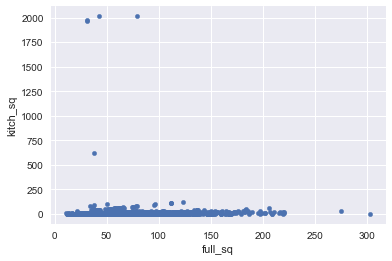

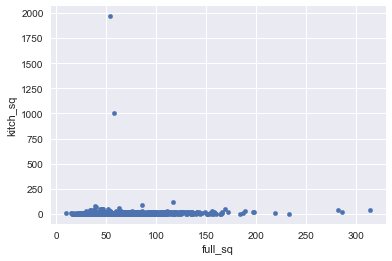

In [55]:
## kitch_sq
train.plot.scatter(x='full_sq', y='kitch_sq')
test.plot.scatter(x='full_sq', y='kitch_sq')

In [56]:
train.loc[(train['kitch_sq'] > train['full_sq']) & (train['kitch_sq'] > 100)]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
10371,2013-09-10,79.0,41.0,5.0,17.0,6.0,2013.0,3.0,2013.0,1.0,OwnerOccupier,Poselenie Voskresenskoe,7281225
11523,2013-10-24,38.0,23.0,11.0,14.0,5.0,1971.0,2.0,620.0,2.0,Investment,Novogireevo,6300000
13120,2013-12-14,31.0,19.0,5.0,1.0,1.0,NaN,1.0,1970.0,3.0,Investment,Izmajlovo,3650000
21418,2014-08-11,43.0,43.0,3.0,1.0,1.0,2014.0,1.0,2014.0,1.0,OwnerOccupier,Poselenie Sosenskoe,3801200
28737,2015-03-31,31.0,16.0,2.0,12.0,5.0,1972.0,1.0,1974.0,3.0,Investment,Matushkino,1000000


In [57]:
train.loc[13120, 'build_year'] = 1970
train.loc[11523, 'kitch_sq'] = train.loc[11523, 'kitch_sq'] / 100
train.loc[train['kitch_sq'] > 200, 'kitch_sq'] = np.nan
train.loc[train['kitch_sq'] < 2, 'kitch_sq'] = np.nan
train.loc[train['kitch_sq'] == train['full_sq'], 'kitch_sq'] = np.nan
train.loc[train['kitch_sq'] == train['life_sq'], 'kitch_sq'] = np.nan

In [58]:
test.loc[(test['kitch_sq'] > test['full_sq']) & (test['kitch_sq'] > 100)]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area
id,,,,,,,,,,,,
31381,2015-09-01,53.9,32.1,3,9,1.0,1968.0,2.0,1968.0,2.0,Investment,Severnoe Medvedkovo
36811,2016-03-19,58.5,58.5,15,17,1.0,2017.0,2.0,1000.0,NaN,OwnerOccupier,Poselenie Desjonovskoe


In [59]:
test.loc[test['kitch_sq'] > 200, 'kitch_sq'] = np.nan
test.loc[test['kitch_sq'] < 1.1, 'kitch_sq'] = np.nan
test.loc[test['kitch_sq'] == test['full_sq'], 'kitch_sq'] = np.nan
test.loc[test['kitch_sq'] == test['life_sq'], 'kitch_sq'] = np.nan

- Check correlation matrix

/Users/chao/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


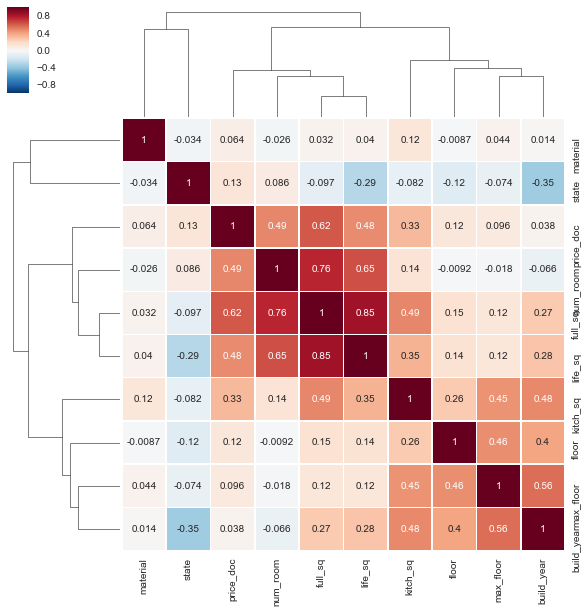

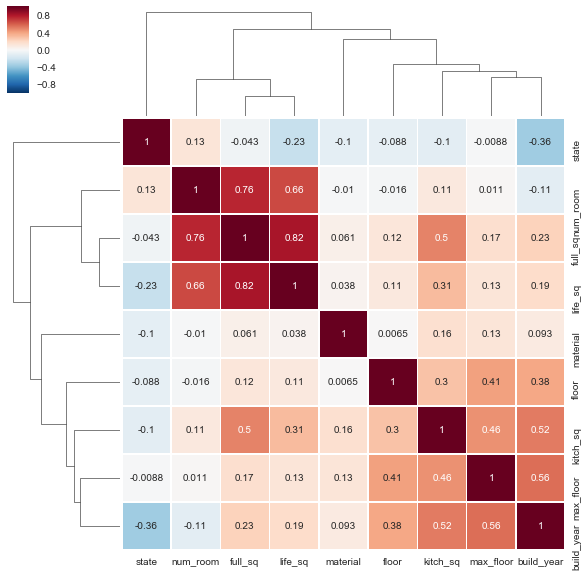

In [60]:
## correlation
vis.corr_plot(train)
vis.corr_plot(test)

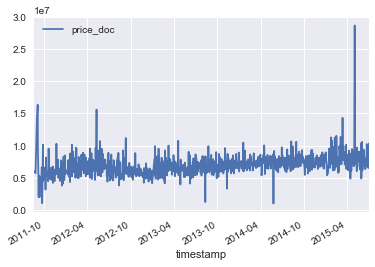

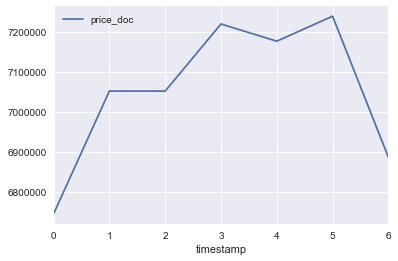

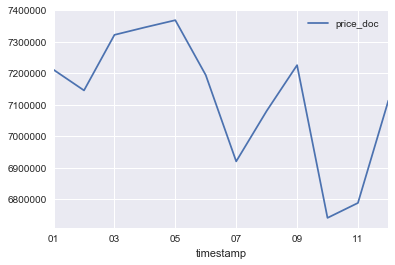

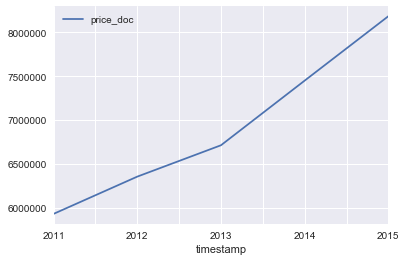

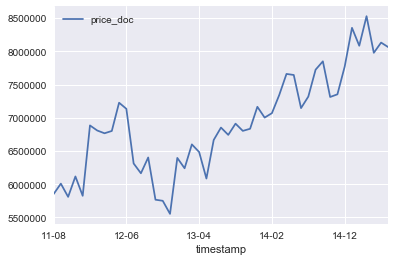

In [61]:
## time series analysis - price_doc

vis.timeseries_plot(train, val='price_doc', by='day')    
vis.timeseries_plot(train, val='price_doc', by='weekday')    
vis.timeseries_plot(train, val='price_doc', by='month')    
vis.timeseries_plot(train, val='price_doc', by='year')
vis.timeseries_plot(train, val='price_doc', by='%Y-%m')

In [62]:
## time series analysis - unit_price

## property square meters
train.loc[:, 'sq_metr'] = train.loc[:, ['full_sq','life_sq']].max(axis=1)

In [63]:
#train.loc[train['sq_metr'] < 6, 'sq_metr'] = np.nan

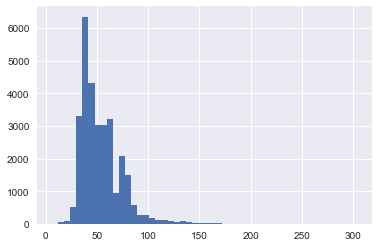

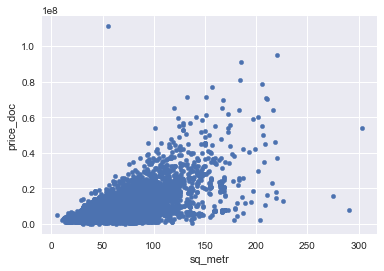

In [64]:
train.loc[:, "sq_metr"].hist(bins=50)
train.plot.scatter(x='sq_metr', y='price_doc')

In [65]:
train.shape
train[train['price_doc'] > 1e8] 

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc,sq_metr
id,,,,,,,,,,,,,,
2121,2012-05-10,55.0,31.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Teplyj Stan,111111112,55.0


In [66]:
## remove outlier (price_doc)
#train = train.drop(train[train['price_doc'] > 1e8].index)
## how about correct the price -- so we don't change the total number of rows
ind_wrongprice = train[train['price_doc'] > 1e8].index
wrongprice     = train.loc[ind_wrongprice,'price_doc']

train.loc[ind_wrongprice,'price_doc'] = wrongprice / 10

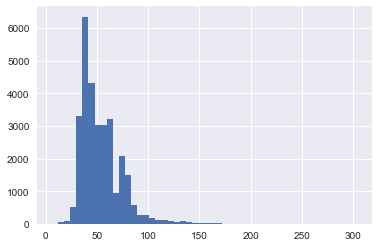

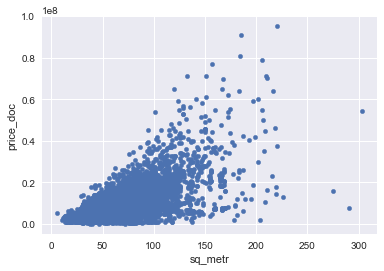

In [67]:
# plot again
train.loc[:, "sq_metr"].hist(bins=50)
train.plot.scatter(x='sq_metr', y='price_doc')

In [68]:
test.loc[:, 'sq_metr'] = test.loc[:, ['full_sq','life_sq']].max(axis=1)

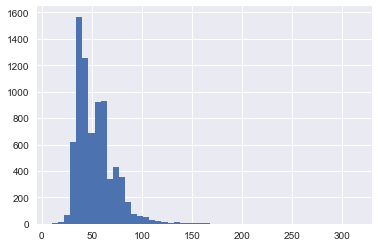

In [69]:
test.loc[:, "sq_metr"].hist(bins=50)

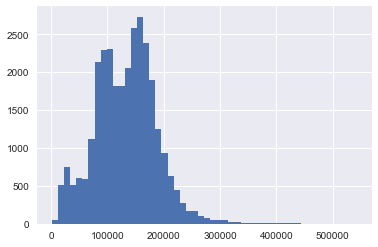

In [70]:
## property unit_price
train.loc[:, 'unit_price'] = train.loc[:, 'price_doc'] / train.loc[:, 'sq_metr']
train.loc[train['unit_price'] > 600000, 'unit_price'] = np.nan
train.loc[:, "unit_price"].hist(bins=50)

In [71]:
train.loc[:, "unit_price"].value_counts(dropna=False).sort_index()

 1388.888889       1
 4255.319149       1
 4788.777778       1
 4857.142857       1
 5000.000000       1
 5256.410256       1
 5368.015152       1
 5738.474576       1
 5903.112500       1
 6000.000000       1
 6024.096386       1
 6039.416058       1
 6186.932584       1
 6275.026316       1
 6329.113924       1
 6500.000000       1
 6896.875000       1
 7080.923077       1
 8088.235294       1
 8389.830508       1
 8474.576271       1
 8780.487805       1
 8958.486486       1
 9000.000000       1
 9090.909091       1
 9210.526316       1
 9433.962264       2
 9611.650485       1
 9615.384615       1
 9677.419355       1
                  ..
 415587.333333     1
 418518.518519     1
 418905.702128     1
 419354.838710     1
 422607.813953     1
 424672.897196     1
 425287.356322     1
 425531.914894     1
 429526.418605     1
 432285.147287     1
 432374.981818     1
 435000.000000     1
 435483.870968     1
 436445.023256     1
 439007.826087     1
 439837.705426     1
 440000.00000

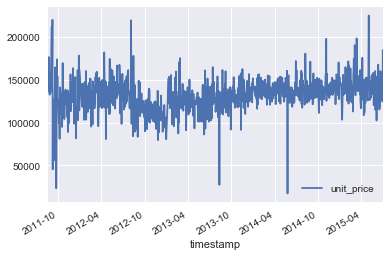

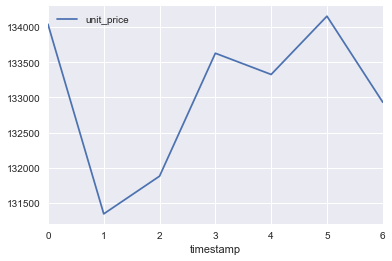

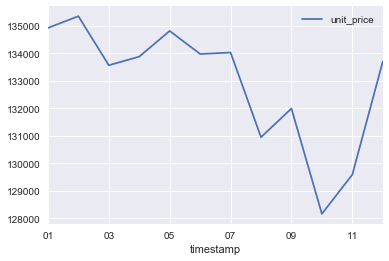

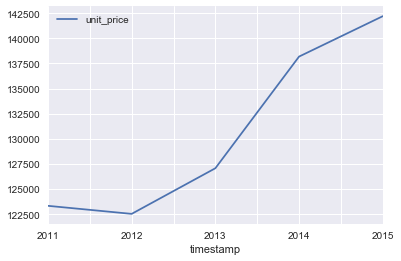

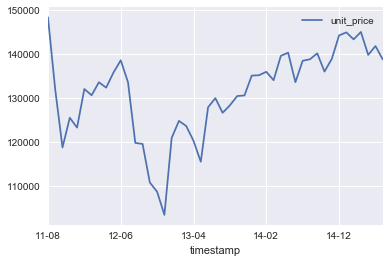

In [72]:
## time series
## unit_price
vis.timeseries_plot(train, val='unit_price', by='day')
vis.timeseries_plot(train, val='unit_price', by='weekday')    
vis.timeseries_plot(train, val='unit_price', by='month')    
vis.timeseries_plot(train, val='unit_price', by='year') 
vis.timeseries_plot(train, val='unit_price', by='%Y-%m') 

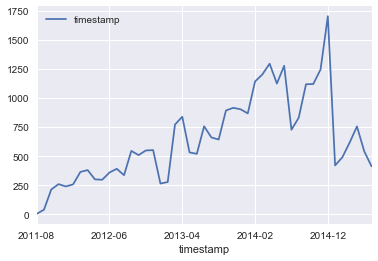

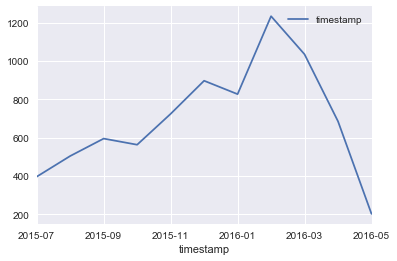

In [73]:
## time series analysis - transaction volumns
by_what = train['timestamp'].apply(lambda x: x.strftime('%Y-%m'))
train.loc[:, ['timestamp']].groupby(by_what).count().plot()

by_what = test['timestamp'].apply(lambda x: x.strftime('%Y-%m'))
test.loc[:, ['timestamp']].groupby(by_what).count().plot()

### 2.2 'price_doc' distribution deep dive

In [74]:
#cols = df_train.columns

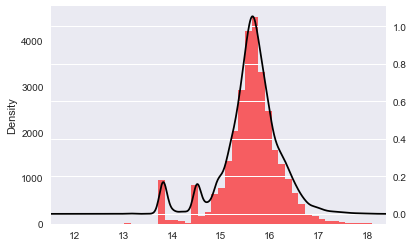

In [75]:
vis.hist_density_plot(train, x='price_doc', logx=True)

# Place Holder
After the log transform, the price distribution is much more symmetric.
Notice the interesting 2 anomalies on the left side of the main peak. They are found to be associated to **product_type == investment**. We will dive into this more.

### 2.3 First Pass Categorical Columns Plot

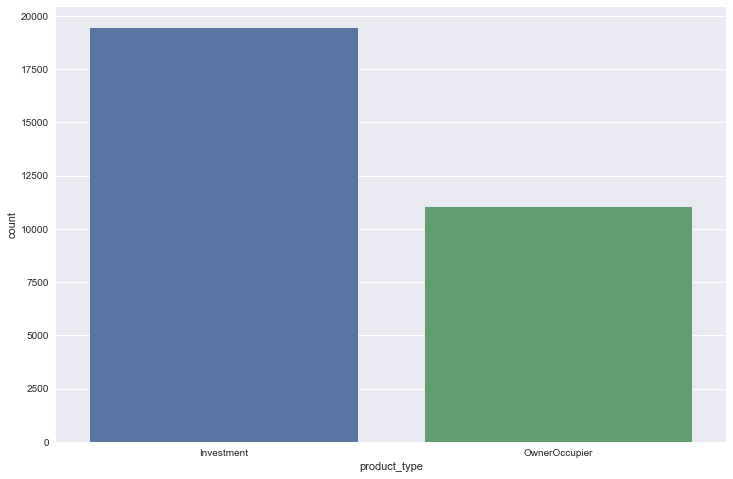

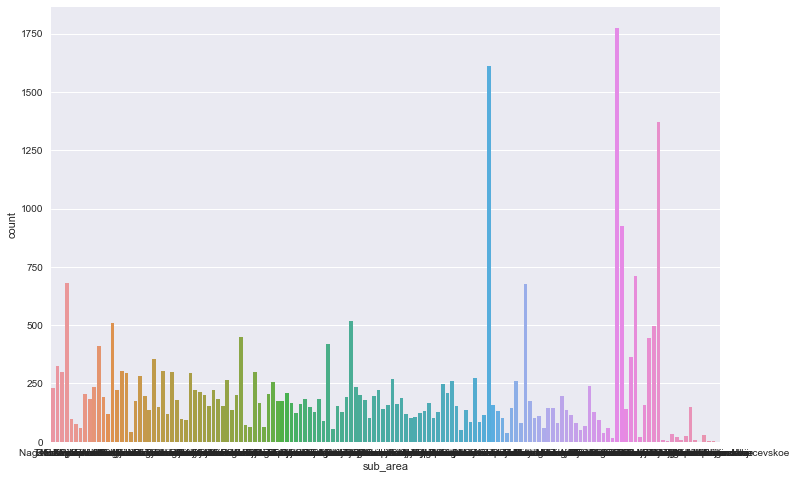

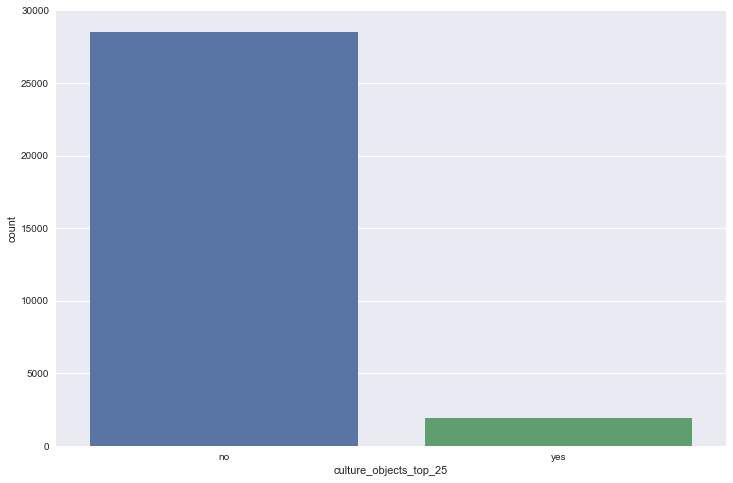

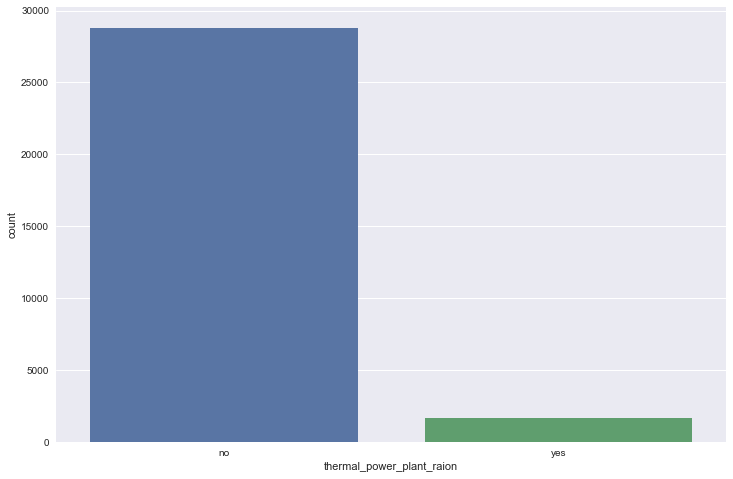

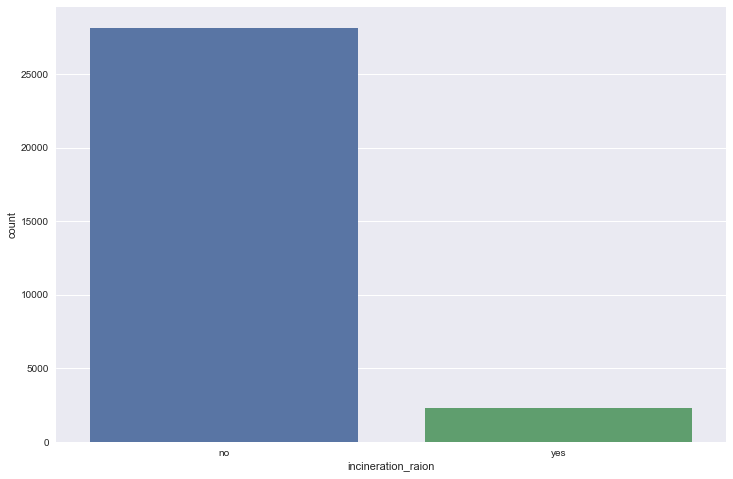

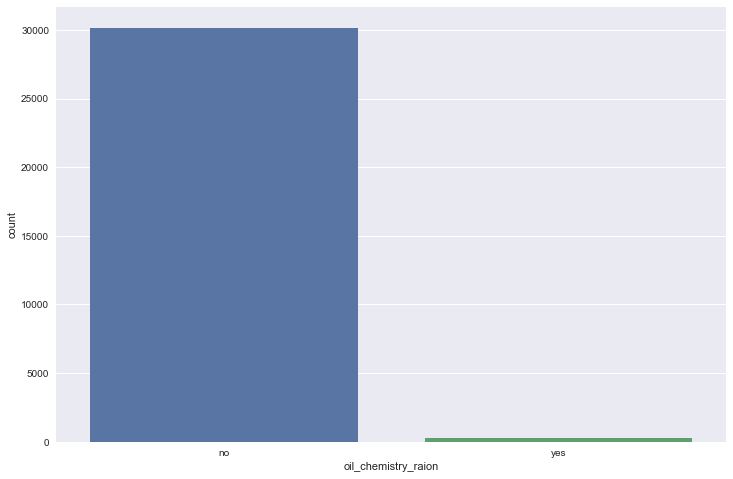

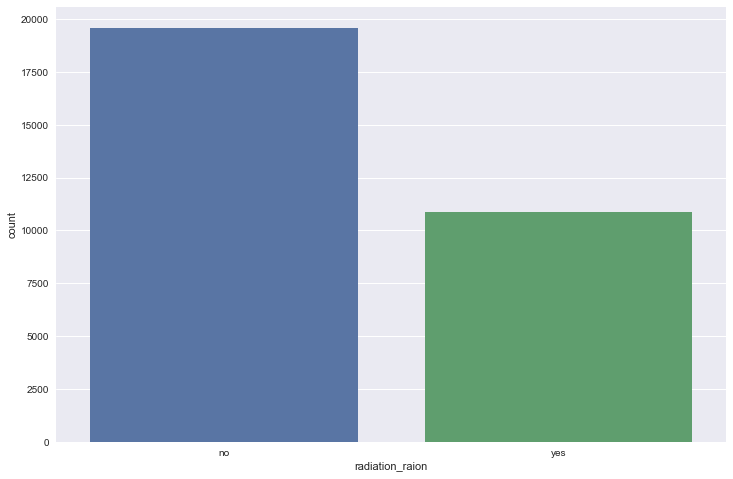

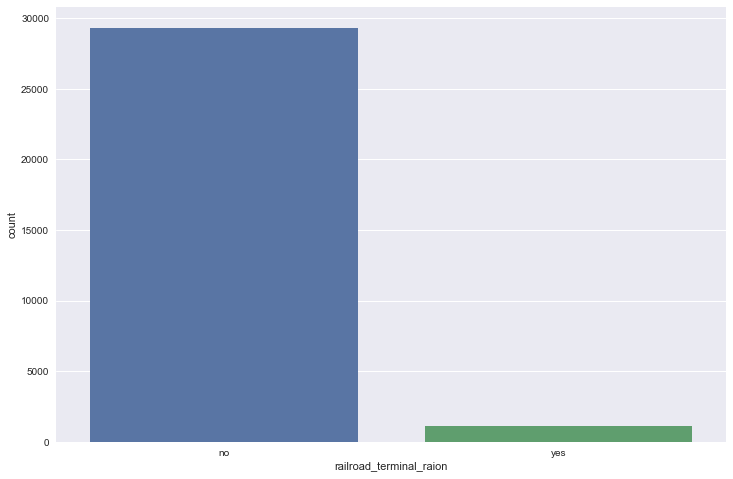

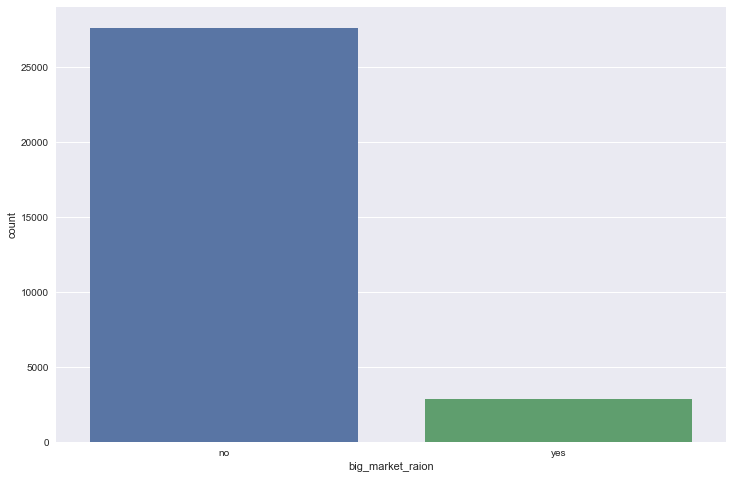

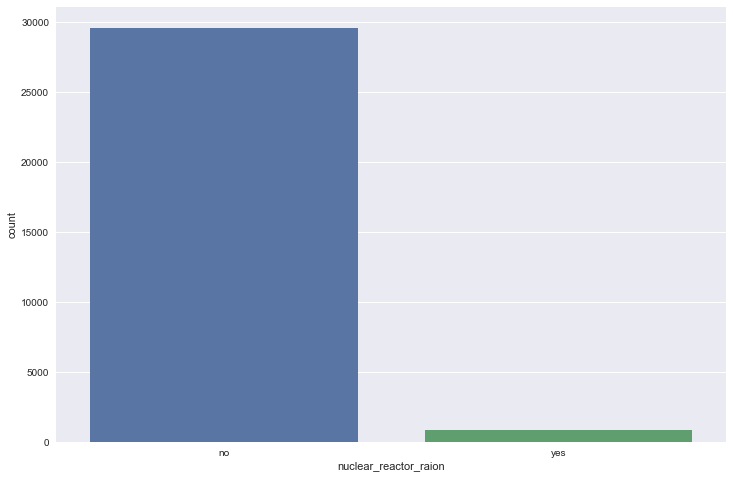

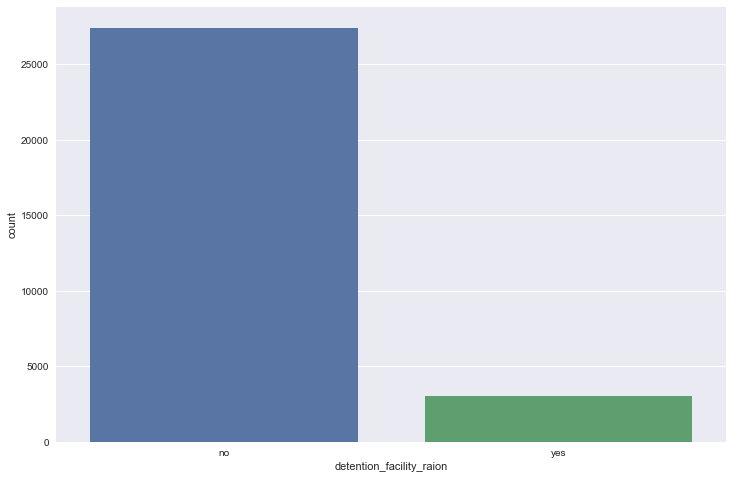

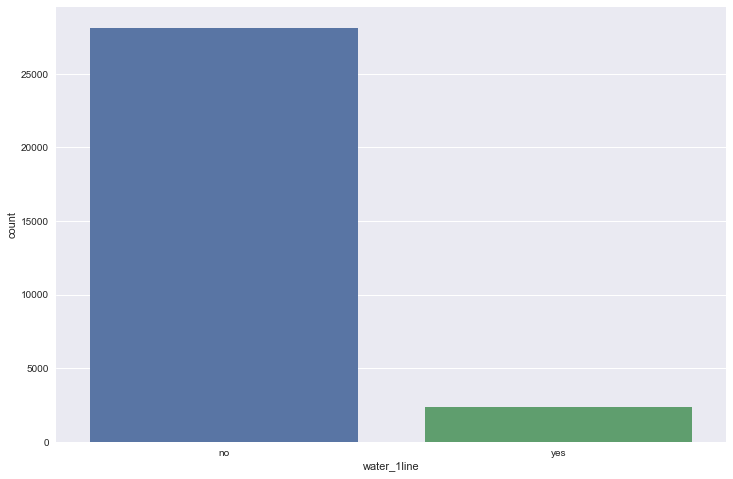

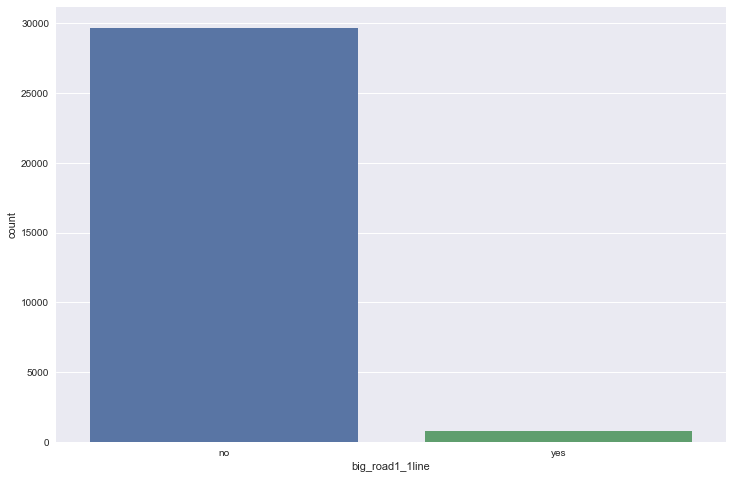

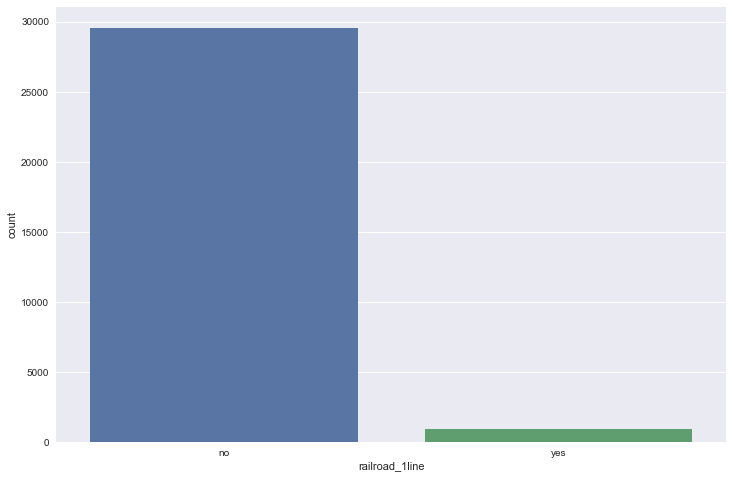

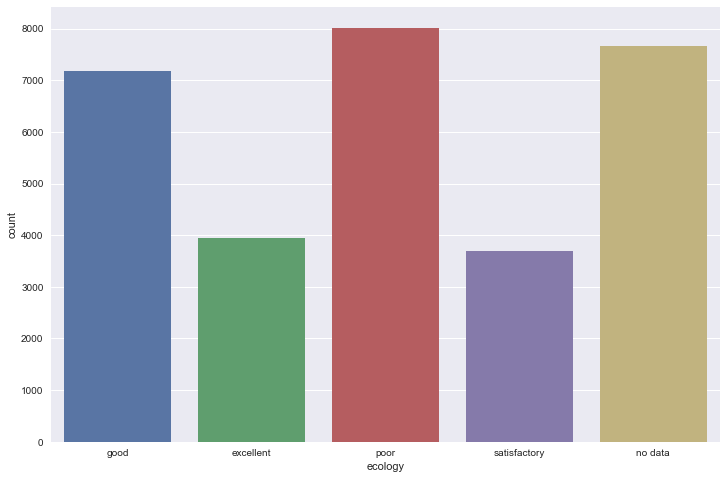

In [76]:
# categorical variables frequency plots
cate_cols = df_train.columns[df_train.dtypes=='object'].tolist()
for i in cate_cols:
    if i not in ['timestamp','yyyy_mm']:
        fg,ax = plt.subplots(figsize=(12,8))
        sns.countplot(x=i,data = df_train)
        plt.show()

In [77]:
# change ID's to categorical variables (as.factor)

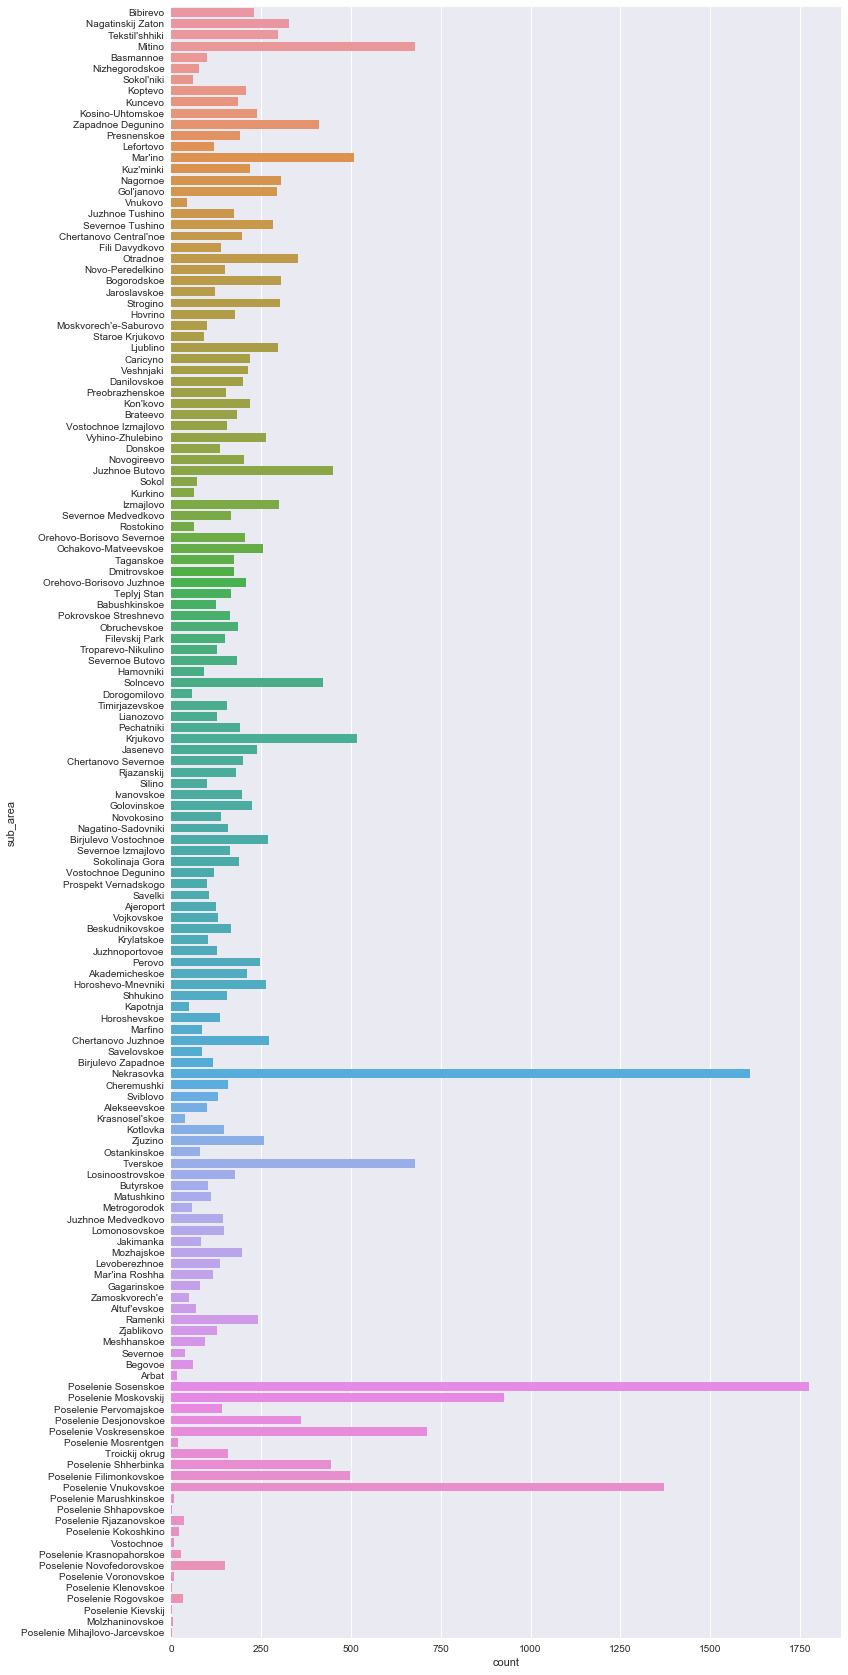

In [78]:
fg,ax = plt.subplots(figsize=(12,30))
sns.countplot(y='sub_area', data=df_train_macro)
plt.show()

### 2.4 Full Correlation Matrix Plot

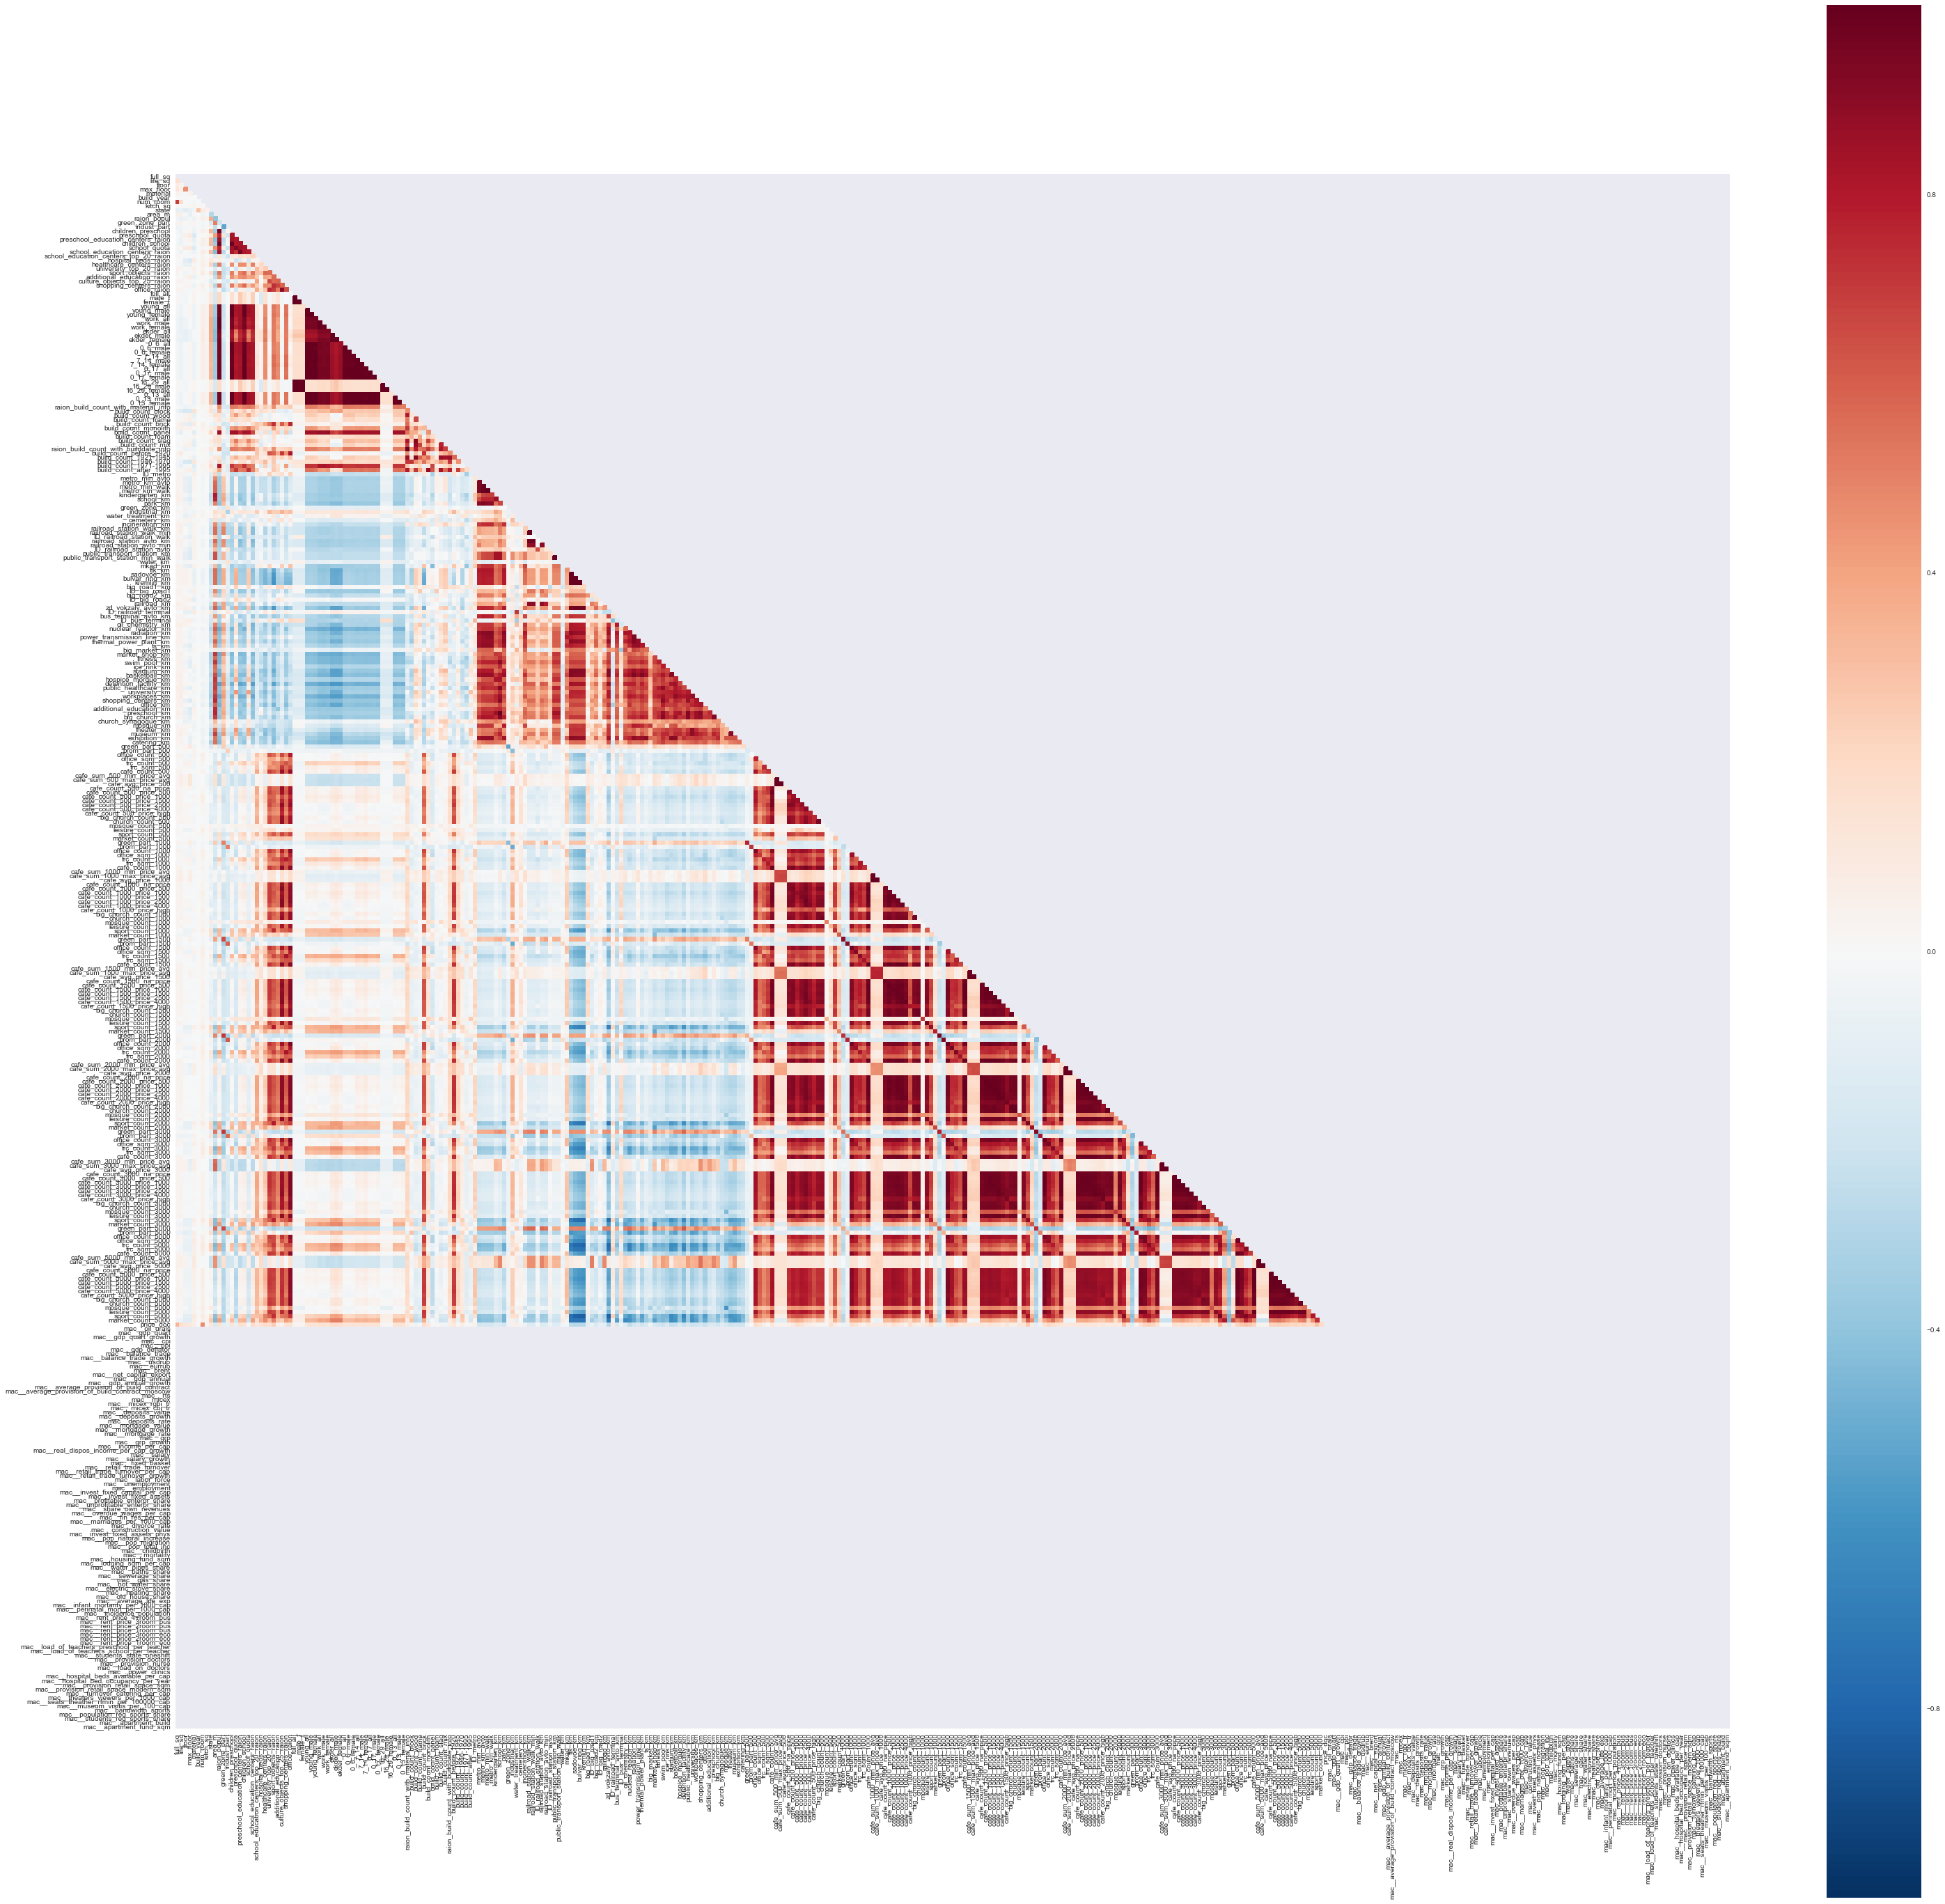

In [79]:
df_train_macro_corr = df_train_macro.corr() 
mask = np.zeros_like(df_train_macro_corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(50, 50))
with  sns.axes_style("white"):
    ax = sns.heatmap(df_train_macro_corr,
#             annot=True,
            mask = mask, 
            square = True
           )
plt.show()

### (Repeated) High Level Column Cotent Digestion -- Now with Corr Mat Plot

'**timestamp**'(0): this is what makes this competition special -- it has a time dimension. **The training data set and test data set do NOT overlap in time**. The macro economy csv files covers the whole time range of train + test.

'**full_sq**' to '**state**'(1-9): these are detailed description of each listing unit. 

'**product_type**'(10): investment or owner occupied

'**sub_area**' to '**build_count_after_1995**'(11-82): neighborhood info. **For all the listings in the same sub_area, all info in col 12-83 are the SAME. When comparing listings in the same sub_area, all these columns are useless.** If we take the intuitive approach to predict price only using the training info from the same sub_area, these columns would be useless. Input and target distribution for each sub_area need to be looked at. 

'**ID_metro**' to '**ecology**'(83-151): These are listing specific info. Most of them are distances (in km) to the nearest POI's. A few of them have **ID**'s, which can be used to further pin down where the listing is within a sub_area, especially with a map. The distance items could be potentially be grouped into 'good' and 'bad' POI's, and do a sum of 1/d to get "number of good/bad stuff per 1 km" feature. A few things like ecology are categorical, and should be important for predicting housing price.

**Everything after ecology till the last column**(152-289): these are POI counts for specific radius. It is important to think about the spatial sensitivity decay when we increase the radius. To reduce multicollinearity, I think it's better to do a few subtraction to get counts in a donut area, so columns are more independent from each other.

'**price_doc**'(290): This is the price we try to predict.

# 3 Feature Engineering and Selection

## 3.1 Macro feature selection based on VIF study on Kaggle forum

In [80]:
# We need to do a similar study

# These are the kept cols after a VIF study in R: https://www.kaggle.com/robertoruiz/dealing-with-multicollinearity
# Someone posted a Python version: https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
# Which might be sped up this way (quickly drop once VIF is higher than a threshold): 
# https://www.kaggle.com/jbucker/sklearn-multicollinearity-class-speedup
macro_cols = ['timestamp','eurub','usdrub','micex_cbi_tr',
              'brent','micex','micex_rgbi_tr',
              'rts','oil_urals','cpi','ppi','quart',
              'rent_price_1room_bus','rent_price_4+room_bus',
              'net_capital_export','mortgage_rate','balance_trade',
              'rent_price_3room_eco','deposits_value','gdp_quart_growth',
              'balance_trade_growth','rent_price_2room_bus','mortage_growth',
              'income_per_cap','rent_price_2room_eco','fixed_basket',
              'rent_price_1room_eco','mortgage_value','rent_price_3room_bus',
              'deposits_rate',"balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
              "micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
              "income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build","timestamp"]
macro_cols = list(set(macro_cols))
len(macro_cols)
# df_macro = df_macro.loc[:,macro_cols]

34

## 3.2 Train set feature generation by Shu

In [81]:
## log transformation
train.loc[:, 'log_price_doc'] = np.log(train['price_doc'] + 1)

In [82]:
## time features
train.loc[:, 'year'] = train.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
train.loc[:, 'month'] = train.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

test.loc[:, 'year'] = test.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
test.loc[:, 'month'] = test.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

In [83]:
## sub_area
# freq_area = np.array(train.loc[:, 'sub_area'].value_counts()[:60].index)

# train.loc[~train['sub_area'].isin(freq_area), 'sub_area'] = 'other'
# test.loc[~test['sub_area'].isin(freq_area), 'sub_area'] = 'other'



## This could (and should) be optimized, since we have map + neighborhood info
## What clustering algorithm can we use here?

In [84]:
print(train.loc[:,'product_type'].value_counts(dropna=False))
print(test.loc[:,'product_type'].value_counts(dropna=False))

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64
Investment       4998
OwnerOccupier    2631
NaN                33
Name: product_type, dtype: int64


In [85]:
## impute test.loc[test['product_type']] for LabelEncoding
test.loc[test['product_type'].isnull(), 'product_type'] = train.loc[:, 'product_type'].mode()[0]

In [86]:
print(train.loc[:,'product_type'].value_counts(dropna=False))
print(test.loc[:,'product_type'].value_counts(dropna=False))

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64
Investment       5031
OwnerOccupier    2631
Name: product_type, dtype: int64


In [87]:
## label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = dict()

for feature in ['product_type', 'sub_area']:
    print('encoding feature: {}'.format(feature))
    label_encoder[feature] = LabelEncoder()
    label_encoder[feature].fit(train[feature])
    train.loc[:, feature + '_le'] = label_encoder[feature].transform(train[feature])
    test.loc[:, feature + '_le'] = label_encoder[feature].transform(test[feature])

encoding feature: product_type
encoding feature: sub_area


## Checkpoint -- Data Update and Output

In [88]:
# original train and test set when they were first generated
train_o = df_train[property_features]
test_o  = df_test[property_features[:-1]]
print train_o.columns
print test_o.columns
# cleaned train and test set
print train.columns  # new features are 'sq_metr', 'unit_price'
print test.columns   # new feature is 'sq_metr'

print train.shape
print df_train.shape
print test.shape
print df_test.shape

Index([u'timestamp', u'full_sq', u'life_sq', u'floor', u'max_floor',
       u'material', u'build_year', u'num_room', u'kitch_sq', u'state',
       u'product_type', u'sub_area', u'price_doc'],
      dtype='object')
Index([u'timestamp', u'full_sq', u'life_sq', u'floor', u'max_floor',
       u'material', u'build_year', u'num_room', u'kitch_sq', u'state',
       u'product_type', u'sub_area'],
      dtype='object')
Index([u'timestamp', u'full_sq', u'life_sq', u'floor', u'max_floor',
       u'material', u'build_year', u'num_room', u'kitch_sq', u'state',
       u'product_type', u'sub_area', u'price_doc', u'sq_metr', u'unit_price',
       u'log_price_doc', u'year', u'month', u'product_type_le',
       u'sub_area_le'],
      dtype='object')
Index([u'timestamp', u'full_sq', u'life_sq', u'floor', u'max_floor',
       u'material', u'build_year', u'num_room', u'kitch_sq', u'state',
       u'product_type', u'sub_area', u'sq_metr', u'year', u'month',
       u'product_type_le', u'sub_area_le'],
      

In [89]:
# update
df_train[property_features] = train[property_features]
df_train['sq_metr']         = train['sq_metr']
df_train['unit_price']      = train['unit_price']
df_train['log_price_doc']   = train['log_price_doc']
df_train['year']            = train['year']
df_train['month']           = train['month']
df_train['product_type_le'] = train['product_type_le']
df_train['sub_area_le']     = train['sub_area_le']

df_test[property_features[:-1]] = test[property_features[:-1]]
df_test['sq_metr']              = test['sq_metr']
df_test['year']                 = test['year']
df_test['month']                = test['month']
df_test['product_type_le']      = test['product_type_le']
df_test['sub_area_le']          = test['sub_area_le']

In [95]:
print df_train.shape
print df_test.shape

(30471, 298)
(7662, 295)


In [96]:
df_train = df_train.merge(df_subarea,on='sub_area',how = 'left')
df_test  = df_test.merge(df_subarea,on='sub_area',how = 'left')

In [97]:
print df_train.shape
print df_test.shape

(30471, 301)
(7662, 298)


In [100]:
df_train.columns.tolist()
df_train.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [101]:
df_train.to_csv('train_clean_shu_lonlat_CS_0518.csv')
df_test.to_csv('test_clean_shu_lonlat_CS_0518.csv')

## 3.3 Normalization Features by Wei (These are not included in the output CSV)

In [90]:
ylog_train_all = np.log1p(df_train['price_doc'].values)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train) # use it to split train test after merge
df_all = pd.concat([df_train, df_test])

# Merge with econ data

df_macro.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in df_macro.columns ]
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')
print(df_all.shape)

df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])

(38133, 397)


### Create new features

timestamp transformation

In [91]:
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

Calculate business density

##### Count density

In [92]:
for i in df_all.columns:
    for j in df_all.columns:
        if ('count_500' in i ) and ('count_5000' not in i) \
           and ('count_1000' in j) and \
            (i.replace('count_500','') == j.replace('count_1000','')):
            col_name = i.replace('count_500','')+'_05km_1km_count_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (1**2-0.5**2))
        elif ('count_1000' in i) and ('count_1500' in j) and \
        (i.replace('count_1000','') == j.replace('count_1500','')):
            col_name = i.replace('count_1000','')+'_1km_1_5km_count_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (1.5**2-1**2))
        elif ('count_1500' in i) and ('count_2000' in j) and \
        (i.replace('count_1500','') == j.replace('count_2000','')):
            col_name = i.replace('count_1500','')+'_1_5km_2km_count_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (2**2-1.5**2))
        elif ('count_2000' in i) and ('count_3000' in j) and \
        (i.replace('count_2000','') == j.replace('count_3000','')):
            col_name = i.replace('count_2000','')+'_2km_3km_count_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (3**2-2**2))
        elif ('count_3000' in i) and ('count_5000' in j) and \
        (i.replace('count_3000','') == j.replace('count_5000','')):
            col_name = i.replace('count_3000','')+'_3km_5km_count_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (5**2-3**2))


In [93]:
# for i in df_all.columns:
#     if ('count_500' in i ) or\
#     ('count_1000' in i ) or\
#     ('count_1500' in i ) or\
#     ('count_2000' in i ) or\
#     ('count_3000' in i ) or\
#     ('count_5000' in i ):
#         df_all.drop([i],axis=1,inplace=True)
# #         print(i)

#### Sqm density

In [94]:
for i in df_all.columns:
    for j in df_all.columns:
        if ('sqm_500' in i ) and ('sqm_5000' not in i) \
           and ('sqm_1000' in j) and \
            (i.replace('sqm_500','') == j.replace('sqm_1000','')):
            col_name = i.replace('sqm_500','')+'_05km_1km_sqm_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (1000**2-500**2))
        elif ('sqm_1000' in i) and ('sqm_1500' in j) and \
        (i.replace('sqm_1000','') == j.replace('sqm_1500','')):
            col_name = i.replace('sqm_1000','')+'_1km_1_5km_sqm_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (1500**2-1000**2))
        elif ('sqm_1500' in i) and ('sqm_2000' in j) and \
        (i.replace('sqm_1500','') == j.replace('sqm_2000','')):
            col_name = i.replace('sqm_1500','')+'_1_5km_2km_sqm_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (2000**2-1500**2))
        elif ('sqm_2000' in i) and ('sqm_3000' in j) and \
        (i.replace('sqm_2000','') == j.replace('sqm_3000','')):
            col_name = i.replace('sqm_2000','')+'_2km_3km_sqm_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (3000**2-2000**2))
        elif ('sqm_3000' in i) and ('sqm_5000' in j) and \
        (i.replace('sqm_3000','') == j.replace('sqm_5000','')):
            col_name = i.replace('sqm_3000','')+'_3km_5km_sqm_density'
            df_all[col_name]= (df_all[j]-df_all[i]) / (math.pi * (5000**2-3000**2))

In [95]:
# for i in df_all.columns:
#     if ('sqm_500' in i ) or\
#     ('sqm_1000' in i ) or\
#     ('sqm_1500' in i ) or\
#     ('sqm_2000' in i ) or\
#     ('sqm_3000' in i ) or\
#     ('sqm_5000' in i ):
#         df_all.drop([i],axis=1,inplace=True)
# #         print(i)

#### Population data transformation

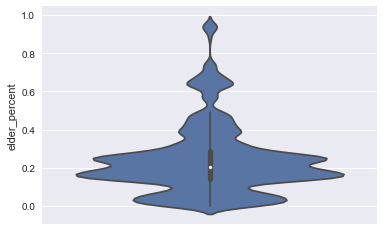

In [96]:
# Aging population
df_all['elder_percent'] = df_all['ekder_all']/df_all['full_all']
df_all.loc[df_all['elder_percent']>1,'elder_percent']=np.mean(df_all.loc[df_all['elder_percent']<=1,'elder_percent'])
sns.violinplot(data=df_all,y='elder_percent')
plt.show()

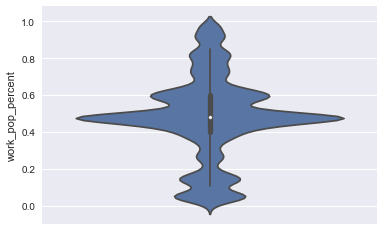

In [97]:
# Working population percentage
df_all['work_pop_percent'] = df_all['work_all']/df_all['full_all']
df_all.loc[df_all['work_pop_percent']>1,'work_pop_percent']=np.mean(df_all.loc[df_all['work_pop_percent']<=1,'work_pop_percent'])
sns.violinplot(data=df_all,y='work_pop_percent')
plt.show()

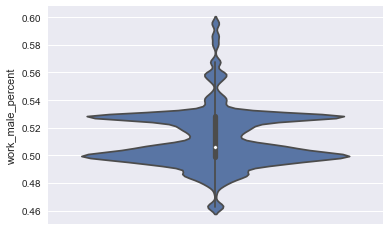

In [98]:
#Working male / working all
df_all['work_male_percent'] = df_all['work_male']/df_all['work_all']
df_all.loc[df_all['work_male_percent']>1,'work_male_percent']=np.mean(df_all.loc[df_all['work_male_percent']<=1,'work_male_percent'])
sns.violinplot(data=df_all,y='work_male_percent')
plt.show()

In [99]:
for i in df_all.columns:
    if ('male' in i) and (i != 'work_male_percent'):
        df_all.drop([i],axis=1, inplace=True)
        print(i)

0_13_female
0_13_male
0_17_female
0_17_male
0_6_female
0_6_male
16_29_female
16_29_male
7_14_female
7_14_male
ekder_female
ekder_male
female_f
male_f
work_female
work_male
young_female
young_male


In [100]:
# region population density
df_all['region_pop_density']=df_all['raion_popul']/df_all['area_m']
df_all['healthcare_center_1k_capita']=df_all['healthcare_centers_raion']/df_all['raion_popul']*1000
df_all['shopping_center_1k_capita']=df_all['shopping_centers_raion']/df_all['raion_popul']*1000
df_all['office_1k_capita']=df_all['office_raion']/df_all['raion_popul']*1000
# df_all['big_market_1k_capita']=df_all['big_market_raion']/df_all['raion_popul']*1000


#### Housing info transformation

In [101]:
# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)
df_all['life_full_sq_ratio'] = df_all['life_sq']/df_all['full_sq']
df_all['avg_room_sq'] = (df_all['life_sq']-df_all['kitch_sq'])/df_all['num_room']


In [102]:
# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp'], axis=1, inplace=True)